In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from math import sqrt

# Latexify function with fallback fonts
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting."""
    assert(columns in [1,2])
    
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9  # width in inches
    
    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0
        fig_height = fig_width*golden_mean
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        fig_height = MAX_HEIGHT_INCHES
    
    params = {
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'font.size': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif'],
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 0.8,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    }
    
    matplotlib.rcParams.update(params)

#### ML Baseline

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# LOAD CSV FILES
# ============================================================================

path = '/home/diya.thakor/AirQuality/BASELINE/results/BaselineResults/'

heuristic_df = pd.read_csv(path + 'heuristic_predictions.csv')
rf_df = pd.read_csv(path + 'randomforest_minimal_test_predictions.csv')
ridge_df = pd.read_csv(path + 'ridge_minimal_test_predictions.csv')
xgboost_df = pd.read_csv(path + 'xgboost_minimal_test_predictions.csv')

print("All baseline files loaded!")

# ============================================================================
# COMPUTE ALL METRICS
# ============================================================================

results = {}

model_configs = [
    (heuristic_df, 'Heuristic', 'PM2.5', 'pred_national_monthly'),
    (rf_df, 'Random Forest', 'PM2.5', 'predicted_PM2.5'),
    (ridge_df, 'Ridge', 'PM2.5', 'predicted_PM2.5'),
    (xgboost_df, 'XGBoost', 'PM2.5', 'predicted_PM2.5'),
]

for df, model_name, actual_col, pred_col in model_configs:
    y_actual = df[actual_col].values
    y_pred = df[pred_col].values
    
    # Overall metrics
    mae_overall = mean_absolute_error(y_actual, y_pred)
    pearson_r, _ = pearsonr(y_actual, y_pred)
    
    # Underprediction (predicted < actual)
    under_mask = y_pred < y_actual
    under_pct = (under_mask.sum() / len(y_actual)) * 100
    mae_under = mean_absolute_error(y_actual[under_mask], y_pred[under_mask]) if under_mask.sum() > 0 else 0
    
    # Overprediction (predicted > actual)
    over_mask = y_pred > y_actual
    over_pct = (over_mask.sum() / len(y_actual)) * 100
    mae_over = mean_absolute_error(y_actual[over_mask], y_pred[over_mask]) if over_mask.sum() > 0 else 0
    
    results[model_name] = {
        'MAE': mae_overall,
        'Pearson_r': pearson_r,
        'Underprediction_%': under_pct,
        'MAE_Under': mae_under,
        'Overprediction_%': over_pct,
        'MAE_Over': mae_over,
    }

# ============================================================================
# CREATE RESULTS TABLE
# ============================================================================

results_df = pd.DataFrame(results).T

print("\n" + "=" * 100)
print("BASELINE MODELS - COMPLETE METRICS")
print("=" * 100)
display(results_df.round(2))

All baseline files loaded!

BASELINE MODELS - COMPLETE METRICS


,MAE,Pearson_r,Underprediction_%,MAE_Under,Overprediction_%,MAE_Over
Heuristic,21.75,0.53,34.21,23.55,65.79,20.81
Random Forest,16.26,0.76,43.12,14.55,56.88,17.56
Ridge,25.36,0.30,34.63,30.17,65.37,22.81
XGBoost,16.72,0.75,40.22,16.52,59.78,16.86


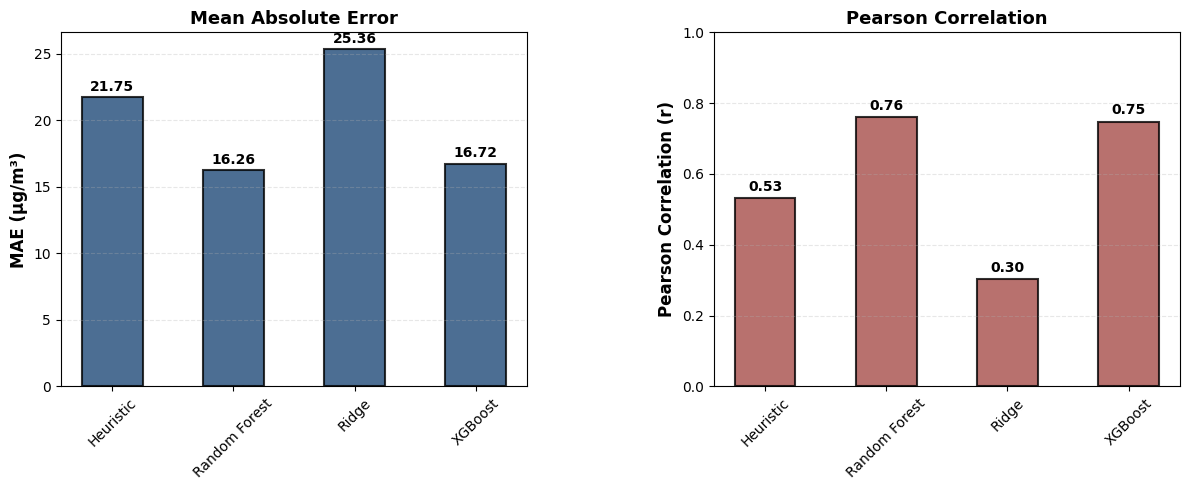

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = results_df.index.tolist()
mae_values = results_df['MAE'].values
pearson_values = results_df['Pearson_r'].values

# Color scheme
color_mae = '#1f4a78'        # Dark blue
color_pearson = '#a64d4a'    # Reddish brown

# Plot 1: MAE
axes[0].bar(models, mae_values, color=color_mae, alpha=0.8, edgecolor='black', linewidth=1.5, width=0.5)
axes[0].set_ylabel('MAE (μg/m³)', fontsize=12, fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, value in enumerate(mae_values):
    axes[0].text(i, value + 0.5, f'{value:.2f}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Pearson Correlation
axes[1].bar(models, pearson_values, color=color_pearson, alpha=0.8, edgecolor='black', linewidth=1.5, width=0.5)
axes[1].set_ylabel('Pearson Correlation (r)', fontsize=12, fontweight='bold')
axes[1].set_title('Pearson Correlation', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, value in enumerate(pearson_values):
    axes[1].text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

#### Pre processing

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
# --------- 1. Load ground truth ----------
ground_truth_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
ground_truth_df['YearMonth'] = pd.to_datetime(ground_truth_df['YearMonth'])
ground_truth_df['year'] = ground_truth_df['YearMonth'].dt.year
ground_truth_df['month'] = ground_truth_df['YearMonth'].dt.month  # use month number
ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'ground_truth_pm25'})
ground_truth_df = ground_truth_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

# --------- 2. Load all models ----------

# Zero-shot models (base responses)
zero_shot_models = [
    (pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv"), 'pm2.5', 'Gemma2-27B-it'),
    (pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv"), 'pm2.5', 'Gemma2-9B-it'),
    (pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv"), 'pm2.5', 'LLaMA3.3-70B-Instruct'),
    (pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_14b_2023_predictions.csv"), 'pm2.5', 'Qwen3-14B'),
    (pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv"), 'pm2.5', 'Qwen3-32B')
]

# Finetuned models (after training)
finetuned_models = [
    (pd.read_csv("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/gemma2_27b_finetuned_test_results.csv"), 'pm2.5_predicted', 'Gemma2-27B-it'),
    (pd.read_csv("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/gemma2_9b_finetuned_test_results.csv"), 'pm2.5_predicted', 'Gemma2-9B-it'),
    (pd.read_csv("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/llama3.3_70b_finetuned_test_results.csv"), 'pm2.5_predicted', 'LLaMA3.3-70B-Instruct'),
    (pd.read_csv("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/qwen3_14b_finetuned_test_results.csv"), 'pm2.5_predicted', 'Qwen3-14B'),
    (pd.read_csv("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/qwen3_32b_finetuned_test_results.csv"), 'pm2.5_predicted', 'Qwen3-32B')
]

llm_models = ['Gemma2-27B-it','Gemma2-9B-it','LLaMA3.3-70B-Instruct','Qwen3-14B','Qwen3-32B']

ml_baselines = [
    (heuristic_df, 'pred_national_monthly', 'Heuristic'),
    (rf_df, 'predicted_PM2.5', 'Random Forest'),
    (ridge_df, 'predicted_PM2.5', 'Ridge'),
    (xgboost_df, 'predicted_PM2.5', 'XGBoost'),
]

In [5]:
model_files = [
    ("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/gemma2_9b_finetuned_test_results.csv", 'Gemma2-9B-it'),
    ("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/gemma2_27b_finetuned_test_results.csv", 'Gemma2-27B-it'),
    ("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/llama3.3_70b_finetuned_test_results.csv", 'LLaMA3.3-70B-Instruct'),
    ("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/qwen3_14b_finetuned_test_results.csv", 'Qwen3-14B'),
    ("/home/diya.thakor/AirQuality/BASELINE/results/LLM_Predictions_RQ1/qwen3_32b_finetuned_test_results.csv", 'Qwen3-32B')
]

In [7]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,1,2023-01-01,196.040103
1,Agartala,Tripura,2023,2,2023-02-01,170.874875
2,Agartala,Tripura,2023,3,2023-03-01,119.490881
3,Agartala,Tripura,2023,4,2023-04-01,94.205356
4,Agartala,Tripura,2023,5,2023-05-01,63.553585


In [6]:
import numpy as np

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05, random_state=0):
    """
    Generic non-parametric bootstrap CI for a scalar metric.
    metric_fn: function(y_true, y_pred) -> float
    Returns (lower, upper, std_boot).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    stats = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower, upper, stats.std(ddof=1)

In [7]:
import numpy as np

def compute_metrics(
    df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    df = df.dropna(subset=["ground_truth_pm25", "pm2.5"])

    if df.empty:
        return {
            "MAE": np.nan,
            "Over %": np.nan,
            "Under %": np.nan,
            "MAEunder": np.nan,
            "MAEover": np.nan,
            "Samples": 0,
            # uncertainty
            "MAE_se": np.nan,
            "MAE_ci_low_param": np.nan,
            "MAE_ci_high_param": np.nan,
            "MAE_ci_low_boot": np.nan,
            "MAE_ci_high_boot": np.nan,
            "MAE_std_boot": np.nan,
        }

    gt = df["ground_truth_pm25"].to_numpy()
    pred = df["pm2.5"].to_numpy()
    n = len(df)

    abs_error = np.abs(gt - pred)
    mae = abs_error.mean()

    # -------- directional errors --------
    under_mask = pred < gt
    over_mask = pred > gt

    mae_under = abs_error[under_mask].mean() if under_mask.any() else np.nan
    mae_over  = abs_error[over_mask].mean()  if over_mask.any() else np.nan

    under_pct = 100 * under_mask.sum() / n
    over_pct  = 100 * over_mask.sum()  / n

    # ===================================
    # Uncertainty estimates for MAE
    # ===================================
    if n > 1:
        # 1) SE (MAE is mean of |error|)
        mae_se = abs_error.std(ddof=1) / np.sqrt(n)

        # 2) Parametric CI
        z = 1.96
        mae_ci_low_param = mae - z * mae_se
        mae_ci_high_param = mae + z * mae_se

        # 3) Bootstrap CI
        if n_bootstrap and n > 5:
            from numpy.random import default_rng
            rng = default_rng(random_state)

            stats = []
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                stats.append(np.mean(np.abs(gt[idx] - pred[idx])))
            stats = np.array(stats)

            mae_ci_low_boot = np.percentile(stats, 100 * alpha / 2)
            mae_ci_high_boot = np.percentile(stats, 100 * (1 - alpha / 2))
            mae_std_boot = stats.std(ddof=1)
        else:
            mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
    else:
        mae_se = mae_ci_low_param = mae_ci_high_param = np.nan
        mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan

    return {
        "MAE": round(mae, 4),
        "Over %": round(over_pct, 4),
        "Under %": round(under_pct, 4),
        "MAEunder": round(mae_under, 4) if not np.isnan(mae_under) else np.nan,
        "MAEover": round(mae_over, 4) if not np.isnan(mae_over) else np.nan,
        "Samples": n,

        # uncertainty outputs (for bar plots)
        "MAE_se": mae_se,
        "MAE_ci_low_param": mae_ci_low_param,
        "MAE_ci_high_param": mae_ci_high_param,
        "MAE_ci_low_boot": mae_ci_low_boot,
        "MAE_ci_high_boot": mae_ci_high_boot,
        "MAE_std_boot": mae_std_boot,
    }

#### Fine tuning

In [8]:
def ensure_year_month_columns(df):
    """
    Returns a DataFrame with 'year' and 'month' columns (both int)
    derived from common variants such as 'YearMonth' or string months.
    """
    if 'year' in df.columns and 'month' in df.columns:
        df['year'] = df['year'].astype(int)
        if df['month'].dtype == 'object':
            month_map = {'january':1, 'february':2, 'march':3, 'april':4, 'may':5, 'june':6,
                         'july':7, 'august':8, 'september':9, 'october':10, 'november':11, 'december':12}
            df['month'] = df['month'].str.lower().map(month_map).astype(int)
        else:
            df['month'] = df['month'].astype(int)
    elif 'YearMonth' in df.columns:
        # often like YYYY-MM or YYYY-MM-DD
        df['YearMonth'] = pd.to_datetime(df['YearMonth'])
        df['year'] = df['YearMonth'].dt.year
        df['month'] = df['YearMonth'].dt.month
    else:
        raise Exception("Cannot find year/month columns.")
    return df

# 2. Evaluation Function (ALL METRICS)
def evaluate_model(model_df, pred_col, model_name, label):
    df = model_df.copy()
    gt = ground_truth_df.copy()
    for d in [df, gt]:
        d['city_lower'] = d['city'].str.strip().str.lower()
        d['state_lower'] = d['state'].str.strip().str.lower()
        d['year'] = d['year'].astype(int)
    if df['month'].dtype == 'object':
        month_map = {'january': 1, 'february': 2, 'march': 3, 'april': 4,
                     'may': 5, 'june': 6, 'july': 7, 'august': 8,
                     'september': 9, 'october': 10, 'november': 11, 'december': 12}
        df['month_num'] = df['month'].str.strip().str.lower().map(month_map)
    else:
        df['month_num'] = df['month'].astype(int)
    gt['month_num'] = gt['month'].astype(int)
    merged = pd.merge(
        df, gt,
        left_on=['city_lower', 'state_lower', 'year', 'month_num'],
        right_on=['city_lower', 'state_lower', 'year', 'month_num'],
        how='inner'
    )
    y_true = merged['ground_truth_pm25']
    y_pred = merged[pred_col]
    valid = (~y_true.isna()) & (~y_pred.isna())
    y_true, y_pred = y_true[valid], y_pred[valid]
    mae = mean_absolute_error(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    under_mask = y_pred < y_true
    over_mask = y_pred > y_true
    under_pct = 100 * under_mask.sum() / len(y_true) if len(y_true) else np.nan
    over_pct = 100 * over_mask.sum() / len(y_true) if len(y_true) else np.nan
    mae_under = mean_absolute_error(y_true[under_mask], y_pred[under_mask]) if under_mask.any() else np.nan
    mae_over = mean_absolute_error(y_true[over_mask], y_pred[over_mask]) if over_mask.any() else np.nan
    return {
        'Model': model_name, 'Type': label,
        'MAE': mae, 'Pearson': pearson_corr, 'Spearman': spearman_corr,
        'Under %': under_pct, 'Over %': over_pct,
        'MAE Under': mae_under, 'MAE Over': mae_over
    }

all_results = [evaluate_model(df, pred_col, name, 'Zero-shot') for df, pred_col, name in zero_shot_models]

all_results += [evaluate_model(df, pred_col, name, 'Finetuned') for df, pred_col, name in finetuned_models]

# ML Baselines
fixed_ml_baselines = []
for df, pred_col, name in ml_baselines:
    df = ensure_year_month_columns(df)
    fixed_ml_baselines.append((df, pred_col, name))

all_results += [evaluate_model(df, pred_col, name, 'ML Baseline') for df, pred_col, name in fixed_ml_baselines]

results_df = pd.DataFrame(all_results)
plot_models = llm_models + ['Heuristic','Random Forest','Ridge','XGBoost']
results_df['Model'] = pd.Categorical(results_df['Model'], plot_models)
types = ['Zero-shot','Finetuned','ML Baseline']
colors = ['#304c75', '#a45b56', '#7bb661']
width = 0.22
x = np.arange(len(plot_models))

# 4. Print/Show Table with All Metrics
print("\n== Performance Table (All Metrics) ==\n")
display(results_df.round(2))

ml_models = ['Heuristic','Random Forest','Ridge','XGBoost']
x_labels = [f'{m}\nZero-shot' for m in llm_models] + [f'{m}\nFinetuned' for m in llm_models] + llm_models


== Performance Table (All Metrics) ==



,Model,Type,MAE,Pearson,Spearman,Under %,Over %,MAE Under,MAE Over
0,Gemma2-27B-it,Zero-shot,34.72,0.58,0.63,12.65,87.35,29.12,35.53
1,Gemma2-9B-it,Zero-shot,27.33,0.25,0.32,40.30,59.70,32.33,23.95
2,LLaMA3.3-70B-Instruct,Zero-shot,46.70,0.55,0.58,12.11,87.89,21.82,50.13
3,Qwen3-14B,Zero-shot,39.13,0.39,0.43,16.17,83.83,29.52,40.99
4,Qwen3-32B,Zero-shot,28.21,0.47,0.47,30.93,69.07,25.40,29.48
5,Gemma2-27B-it,Finetuned,28.21,0.57,0.62,62.94,37.06,22.76,37.47
6,Gemma2-9B-it,Finetuned,17.45,0.72,0.74,51.66,48.34,17.43,17.47
7,LLaMA3.3-70B-Instruct,Finetuned,16.60,0.73,0.75,54.09,45.91,17.02,16.11
8,Qwen3-14B,Finetuned,16.42,0.73,0.76,49.95,50.05,17.80,15.05
9,Qwen3-32B,Finetuned,20.92,0.62,0.66,49.95,50.05,19.82,22.02


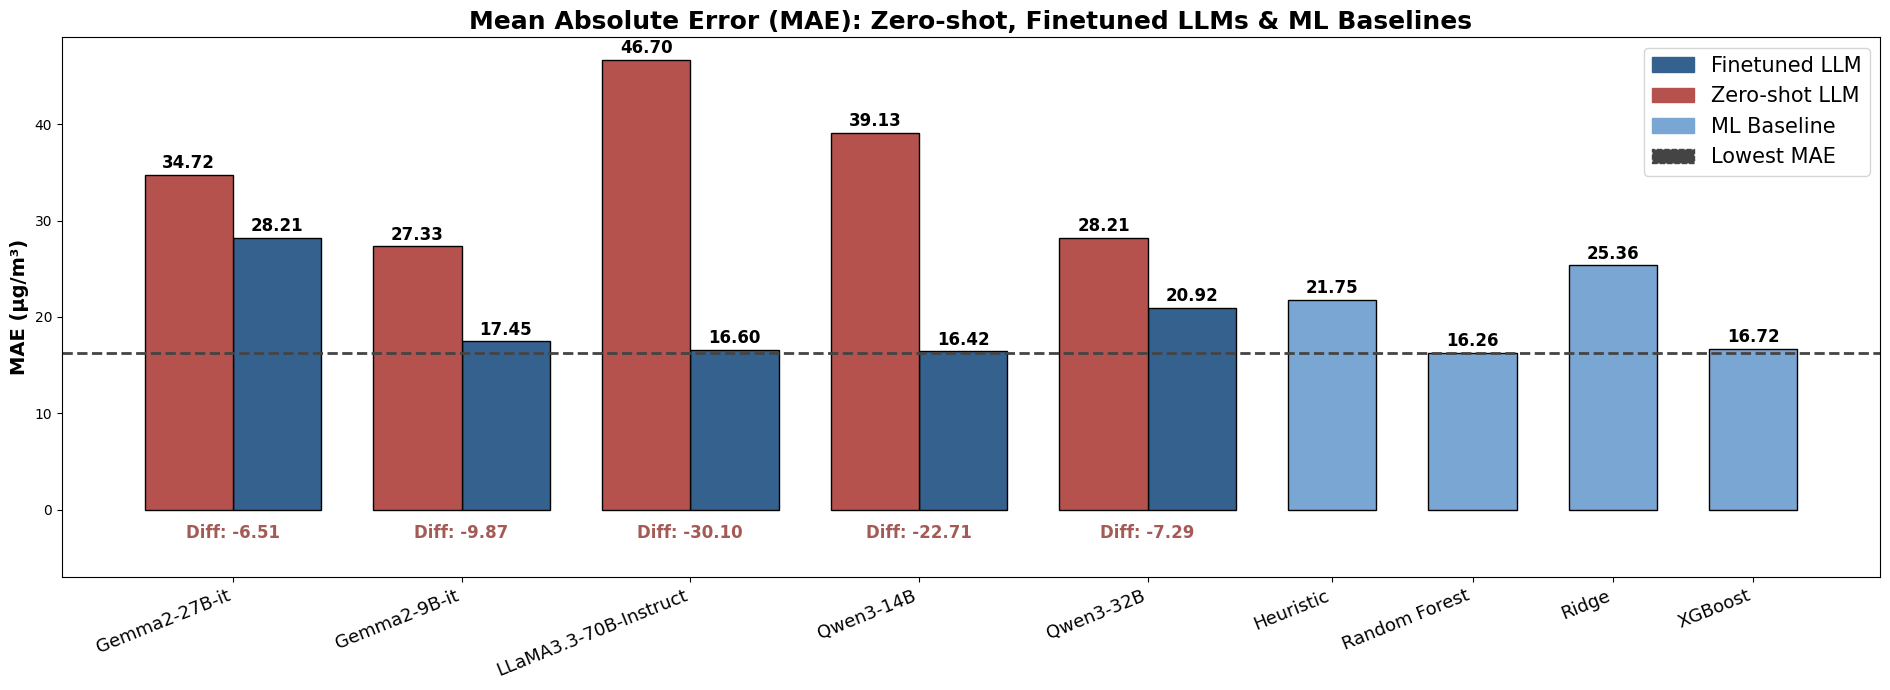

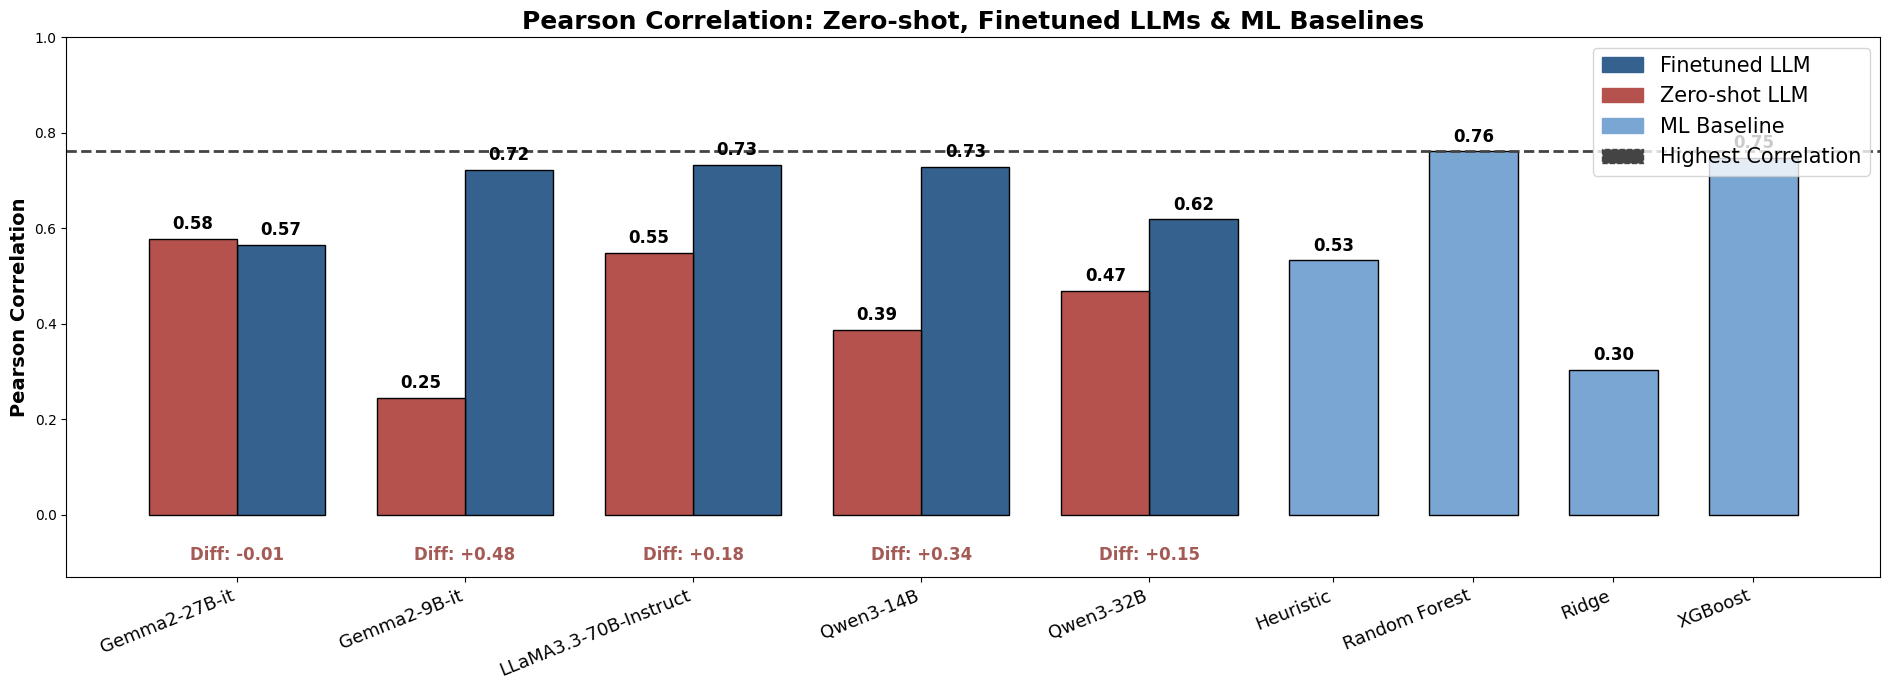

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ml_models = ['Heuristic','Random Forest','Ridge','XGBoost']
group_names = llm_models + ml_models

# Get values
zero_mae = [results_df.query("Model==@m and Type=='Zero-shot'")['MAE'].values[0] for m in llm_models]
fine_mae = [results_df.query("Model==@m and Type=='Finetuned'")['MAE'].values[0] for m in llm_models]
ml_mae   = [results_df.query("Model==@m and Type=='ML Baseline'")['MAE'].values[0] for m in ml_models]

zero_corr = [results_df.query("Model==@m and Type=='Zero-shot'")['Pearson'].values[0] for m in llm_models]
fine_corr = [results_df.query("Model==@m and Type=='Finetuned'")['Pearson'].values[0] for m in llm_models]
ml_corr   = [results_df.query("Model==@m and Type=='ML Baseline'")['Pearson'].values[0] for m in ml_models]

bar_width = 0.34
gap_width = 0.20 # space between groups
n_llms = len(llm_models)

# Bar positions: each model has 2 bars, spaced by bar_width, then a gap before the next model
x_llms = []
xticks = []
for i in range(n_llms):
    pos = i * (2*bar_width + gap_width)
    x_llms.extend([pos, pos + bar_width])
    xticks.append(pos + bar_width/2)
x_mls_base = x_llms[-1] + bar_width + gap_width # start ML at far right
x_mls = [x_mls_base + i*(bar_width+gap_width) for i in range(len(ml_models))]
x_all = x_llms + x_mls
xticks += x_mls

# --- MAE Plot ---
plt.figure(figsize=(19,7))
# Finetuned (blue)
plt.bar([x_llms[i*2+1] for i in range(n_llms)], fine_mae, width=bar_width, color='#35618f', label='Finetuned', edgecolor='black')
# Zero-shot (red)
plt.bar([x_llms[i*2] for i in range(n_llms)], zero_mae, width=bar_width, color='#b5524e', label='Zero-shot', edgecolor='black')
# ML Baseline (blueish)
plt.bar(x_mls, ml_mae, width=bar_width, color='#7aa6d3', label='ML Baseline', edgecolor='black')

# Numeric labels
for idx in range(n_llms):
    plt.text(x_llms[idx*2], zero_mae[idx]+0.7, f"{zero_mae[idx]:.2f}", ha='center', fontsize=12, fontweight='bold')
    plt.text(x_llms[idx*2+1], fine_mae[idx]+0.7, f"{fine_mae[idx]:.2f}", ha='center', fontsize=12, fontweight='bold')
for idx, val in enumerate(ml_mae):
    plt.text(x_mls[idx], val+0.7, f"{val:.2f}", ha='center', fontsize=12, fontweight='bold')

# Diff annotation centered below LLM pair
for idx, (z, f) in enumerate(zip(zero_mae, fine_mae)):
    plt.text(xticks[idx], -3, f"Diff: {f-z:+.2f}", ha='center', fontsize=12, color='#a45b56', fontweight='bold')

plt.xticks(xticks, group_names, rotation=22, ha='right', fontsize=13)
plt.ylabel('MAE (μg/m³)', fontsize=14, fontweight='bold')
plt.title('Mean Absolute Error (MAE): Zero-shot, Finetuned LLMs & ML Baselines', fontsize=18, fontweight='bold')
plt.axhline(min(zero_mae + fine_mae + ml_mae), ls='--', color='#444', lw=2, label='Lowest MAE')
plt.ylim(bottom=-7)
plt.legend(handles=[
    mpatches.Patch(color='#35618f', label='Finetuned LLM'),
    mpatches.Patch(color='#b5524e', label='Zero-shot LLM'),
    mpatches.Patch(color='#7aa6d3', label='ML Baseline'),
    mpatches.Patch(color='#444444', label='Lowest MAE', linestyle='--')
], loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

# --- Pearson Plot (same style) ---
plt.figure(figsize=(19,7))
plt.bar([x_llms[i*2+1] for i in range(n_llms)], fine_corr, width=bar_width, color='#35618f', label='Finetuned', edgecolor='black')
plt.bar([x_llms[i*2] for i in range(n_llms)], zero_corr, width=bar_width, color='#b5524e', label='Zero-shot', edgecolor='black')
plt.bar(x_mls, ml_corr, width=bar_width, color='#7aa6d3', label='ML Baseline', edgecolor='black')
for idx in range(n_llms):
    plt.text(x_llms[idx*2], zero_corr[idx]+0.02, f"{zero_corr[idx]:.2f}", ha='center', fontsize=12, fontweight='bold')
    plt.text(x_llms[idx*2+1], fine_corr[idx]+0.02, f"{fine_corr[idx]:.2f}", ha='center', fontsize=12, fontweight='bold')
for idx, val in enumerate(ml_corr):
    plt.text(x_mls[idx], val+0.02, f"{val:.2f}", ha='center', fontsize=12, fontweight='bold')
for idx, (z, f) in enumerate(zip(zero_corr, fine_corr)):
    plt.text(xticks[idx], -0.095, f"Diff: {f-z:+.2f}", ha='center', fontsize=12, color='#a45b56', fontweight='bold')
plt.xticks(xticks, group_names, rotation=22, ha='right', fontsize=13)
plt.ylabel('Pearson Correlation', fontsize=14, fontweight='bold')
plt.title('Pearson Correlation: Zero-shot, Finetuned LLMs & ML Baselines', fontsize=18, fontweight='bold')
plt.axhline(max(zero_corr + fine_corr + ml_corr), ls='--', color='#444', lw=2, label='Highest Correlation')
plt.ylim(bottom=-0.13, top=1)
plt.legend(handles=[
    mpatches.Patch(color='#35618f', label='Finetuned LLM'),
    mpatches.Patch(color='#b5524e', label='Zero-shot LLM'),
    mpatches.Patch(color='#7aa6d3', label='ML Baseline'),
    mpatches.Patch(color='#444444', label='Highest Correlation', linestyle='--')
], loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

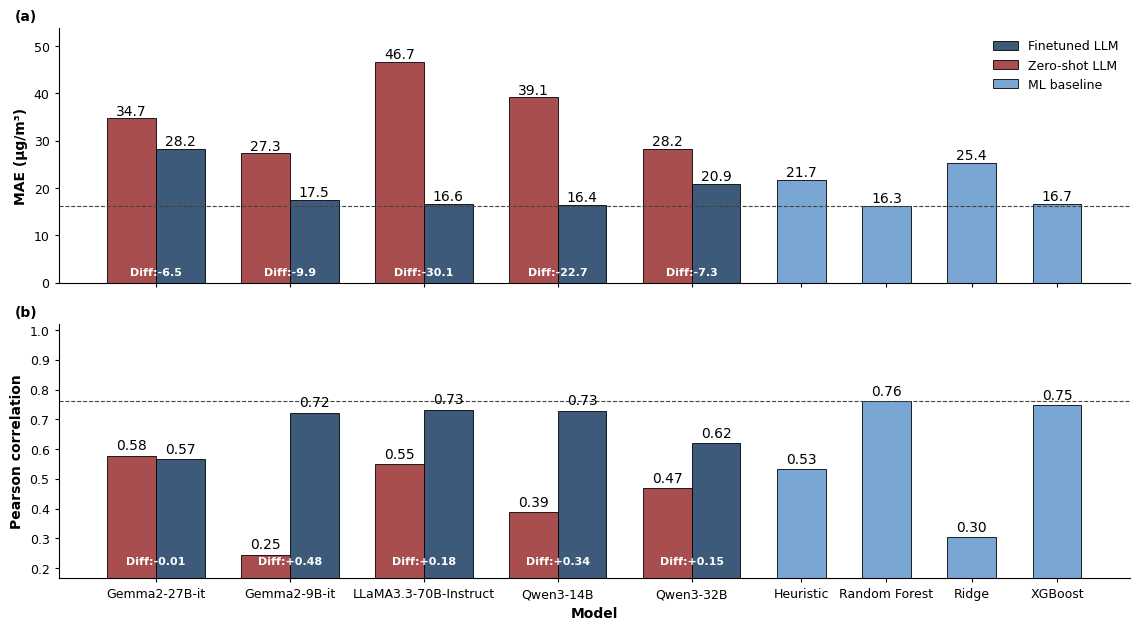

In [26]:
# ---------- data prep ----------
ml_models = ['Heuristic', 'Random Forest', 'Ridge', 'XGBoost']
group_names = llm_models + ml_models

zero_mae = [results_df.query("Model==@m and Type=='Zero-shot'")['MAE'].values[0]
            for m in llm_models]
fine_mae = [results_df.query("Model==@m and Type=='Finetuned'")['MAE'].values[0]
            for m in llm_models]
ml_mae   = [results_df.query("Model==@m and Type=='ML Baseline'")['MAE'].values[0]
            for m in ml_models]

zero_corr = [results_df.query("Model==@m and Type=='Zero-shot'")['Pearson'].values[0]
             for m in llm_models]
fine_corr = [results_df.query("Model==@m and Type=='Finetuned'")['Pearson'].values[0]
             for m in llm_models]
ml_corr   = [results_df.query("Model==@m and Type=='ML Baseline'")['Pearson'].values[0]
             for m in ml_models]

bar_width = 0.24
gap_width = 0.18
n_llms = len(llm_models)

# x positions for all models (LLMs + ML)
x_llms = []
xticks = []
for i in range(n_llms):
    pos = i * (2 * bar_width + gap_width)
    x_llms.extend([pos - bar_width/2, pos + bar_width/2])
    xticks.append(pos)

x_mls_base = x_llms[-1] + bar_width + gap_width
x_mls = [x_mls_base + i * (bar_width + gap_width) for i in range(len(ml_models))]
xticks_all = xticks + x_mls

c_fine = '#3D5A7B'
c_zero = '#A94E4E'
c_ml   = '#7aa6d3'

# ---------- combined figure (MAE + Pearson) ----------
latexify(fig_width=11.5, fig_height=6.4, columns=2)

fig, (ax_mae, ax_r) = plt.subplots(2, 1, figsize=(11.5, 6.4), sharex=True)

# ===== (a) MAE =====
ax = ax_mae

ax.bar([x_llms[i*2+1] for i in range(n_llms)], fine_mae,
       width=bar_width, color=c_fine, edgecolor='black', linewidth=0.6,
       label='Finetuned LLM')
ax.bar([x_llms[i*2] for i in range(n_llms)], zero_mae,
       width=bar_width, color=c_zero, edgecolor='black', linewidth=0.6,
       label='Zero-shot LLM')
ax.bar(x_mls, ml_mae,
       width=bar_width, color=c_ml, edgecolor='black', linewidth=0.6,
       label='ML baseline')

for i in range(n_llms):
    ax.text(x_llms[2*i],     zero_mae[i] + 0.7, f'{zero_mae[i]:.1f}',
            ha='center')
    ax.text(x_llms[2*i + 1], fine_mae[i] + 0.7, f'{fine_mae[i]:.1f}',
            ha='center')
for j, val in enumerate(ml_mae):
    ax.text(x_mls[j], val + 0.7, f'{val:.1f}',
            ha='center')

ymax_mae = max(zero_mae + fine_mae + ml_mae) * 1.15
ax.set_ylim(0, ymax_mae)

# Diff text just above x-axis
for i, (z, f) in enumerate(zip(zero_mae, fine_mae)):
    mid_x = xticks[i]
    ax.text(mid_x, 1.2, f'Diff:{f-z:+.1f}',
            ha='center', va='bottom',
            color='white', fontweight='bold', fontsize=8)

ax.set_ylabel('MAE (µg/m³)', fontweight='bold')
ax.legend(frameon=False, loc='upper right')
ax.grid(False)
# ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.set_axisbelow(True)
ax.tick_params(width=0.8, length=3)
ax.text(-0.02, 1.02, '(a)', transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

# dashed line for best MAE
best_mae = min(zero_mae + fine_mae + ml_mae)
ax.axhline(best_mae, ls='--', color='#444', lw=0.8)

# ===== (b) Pearson r =====
ax = ax_r

ax.bar([x_llms[i*2+1] for i in range(n_llms)], fine_corr,
       width=bar_width, color=c_fine, edgecolor='black', linewidth=0.6,
       label='Finetuned LLM')
ax.bar([x_llms[i*2] for i in range(n_llms)], zero_corr,
       width=bar_width, color=c_zero, edgecolor='black', linewidth=0.6,
       label='Zero-shot LLM')
ax.bar(x_mls, ml_corr,
       width=bar_width, color=c_ml, edgecolor='black', linewidth=0.6,
       label='ML baseline')

for i in range(n_llms):
    ax.text(x_llms[2*i],     zero_corr[i] + 0.02, f'{zero_corr[i]:.2f}',
            ha='center')
    ax.text(x_llms[2*i + 1], fine_corr[i] + 0.02, f'{fine_corr[i]:.2f}',
            ha='center')
for j, val in enumerate(ml_corr):
    ax.text(x_mls[j], val + 0.02, f'{val:.2f}',
            ha='center')

ymax_r = 1.02
ymin_r = min(zero_corr + fine_corr + ml_corr) - 0.08
ax.set_ylim(ymin_r, ymax_r)

# Diff text just above x-axis for Pearson
for i, (z, f) in enumerate(zip(zero_corr, fine_corr)):
    mid_x = xticks[i]
    ax.text(mid_x, ymin_r + 0.04, f'Diff:{f-z:+.2f}',
            ha='center', va='bottom',
            color='white', fontweight='bold', fontsize=8)

ax.set_ylabel('Pearson correlation', fontweight='bold')
ax.set_xlabel('Model', fontweight='bold')
ax.set_xticks(xticks_all)
ax.set_xticklabels(group_names)
ax.grid(False)
# ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.set_axisbelow(True)
ax.tick_params(width=0.8, length=3)
ax.text(-0.02, 1.02, '(b)', transform=ax.transAxes, fontweight='bold', va='bottom', ha='right')

best_r = max(zero_corr + fine_corr + ml_corr)
ax.axhline(best_r, ls='--', color='#444', lw=0.8)

plt.tight_layout()
plt.savefig('finetune_r_mae.pdf', dpi=300,
            bbox_inches='tight', format='pdf')
plt.show()

#### Seasonal trend

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Use full month names for consistent X axis
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
x = np.arange(len(month_order))

# Compute GT monthly means
gt_month_map = dict(zip(range(1, 13), month_order))
ground_truth_df['month_name'] = ground_truth_df['month'].map(gt_month_map)
gt_monthly = ground_truth_df.groupby('month_name')['ground_truth_pm25'].mean().reindex(month_order)


finetuned_mon_means = {}  # model_name -> (mean by month)
for df,_, name in finetuned_models:
    # Ensure correct month column as int 1-12 and "month_name" to map to month_order
    if 'month' in df.columns:
        df['month'] = df['month'].astype(int)
    df['month_name'] = df['month'].map(gt_month_map)
    finetuned_mon_means[name] = df.groupby('month_name')['pm2.5_predicted'].mean().reindex(month_order)

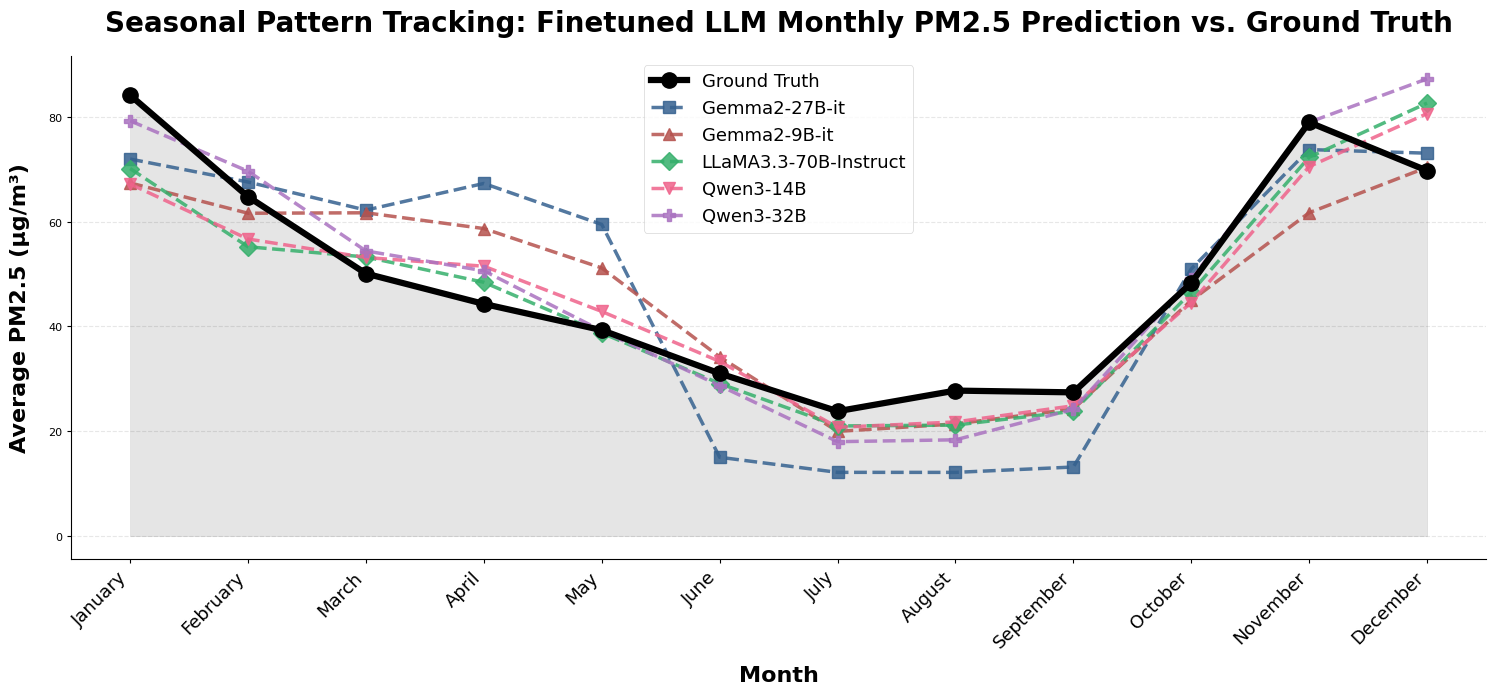

In [12]:

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(15, 7))

# Plot black ground truth
ax.plot(x, gt_monthly.values, marker='o', linewidth=4.5, markersize=11,
        label='Ground Truth', color='black', linestyle='-', zorder=10)
ax.fill_between(x, 0, gt_monthly.values, alpha=0.10, color='black', zorder=1)

# Distinct colors/markers for each LLM (revise to your style as needed)
finetuned_colors = ['#35618f', '#b5524e', '#35af6b', '#ef638b', '#aa72c0']
markers = ['s', '^', 'D', 'v', 'P', 'h']

for i, name in enumerate(finetuned_mon_means.keys()):
    ax.plot(x, finetuned_mon_means[name].values, marker=markers[i % len(markers)], linewidth=2.5,
            markersize=9, label=name, color=finetuned_colors[i % len(finetuned_colors)], alpha=0.85, linestyle='--')

ax.set_title('Seasonal Pattern Tracking: Finetuned LLM Monthly PM2.5 Prediction vs. Ground Truth', fontsize=20, fontweight='bold', pad=18)
ax.set_ylabel('Average PM2.5 (μg/m³)', fontsize=16, fontweight='bold', labelpad=13)
ax.set_xlabel('Month', fontsize=16, fontweight='bold', labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(month_order, rotation=45, ha='right', fontsize=13)
ax.set_xlim(-0.5, len(month_order) - 0.5)
ax.legend(fontsize=13, frameon=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_city_seasonality(model_df, pred_col, gt_df=ground_truth_df, threshold=0.5):
    df = model_df.copy()
    gt = gt_df.copy()

    # Standardize city/state
    for col in ['city', 'state']:
        if col in df.columns:
            df[col] = df[col].str.lower().str.strip()
        if col in gt.columns:
            gt[col] = gt[col].str.lower().str.strip()

    # Map month names → numbers if needed
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    if df['month'].dtype == object:
        df['month'] = df['month'].map(month_map)

    # Ensure month/year numeric
    df['month'] = df['month'].astype(int)
    df['year'] = df['year'].astype(int)
    gt['month'] = gt['month'].astype(int)
    gt['year'] = gt['year'].astype(int)

    # Merge
    merged = pd.merge(
        df,
        gt[['city', 'state', 'year', 'month', 'ground_truth_pm25']],
        on=['city', 'state', 'year', 'month'],
        how='inner'
    )

    city_corrs = []
    month_order = ['january', 'february', 'march', 'april', 'may', 'june',
                   'july', 'august', 'september', 'october', 'november', 'december']

    # month_name
    if 'month_name' not in merged.columns:
        merged['month_name'] = merged['month'].apply(lambda x: month_order[x - 1])
    else:
        merged['month_name'] = merged['month_name'].str.lower()

    # Correlations
    for city, g in merged.groupby('city'):
        g_month = (
            g.groupby('month_name')[[pred_col, 'ground_truth_pm25']]
             .mean()
             .reindex(month_order)
        ).dropna()

        if len(g_month) >= 8:
            pred_vals = g_month[pred_col].values
            gt_vals = g_month['ground_truth_pm25'].values
            if np.std(pred_vals) > 0 and np.std(gt_vals) > 0:
                r = np.corrcoef(pred_vals, gt_vals)[0, 1]
                city_corrs.append(r)

    city_corrs = np.array(city_corrs)
    n_cities = len(city_corrs)
    pct_good = 100 * np.sum(city_corrs >= threshold) / n_cities if n_cities > 0 else 0
    return pct_good, n_cities

# ---- compute for zero-shot and finetuned ----
seasonal_stats_zero = []
seasonal_stats_fine = []

for df, pred_col, name in zero_shot_models:
    pct, n = compute_city_seasonality(df, pred_col)
    seasonal_stats_zero.append({'model': name, 'n_cities_zero': n, 'pct_zero': pct})

for df, pred_col, name in finetuned_models:
    pct, n = compute_city_seasonality(df, pred_col)
    seasonal_stats_fine.append({'model': name, 'n_cities_fine': n, 'pct_fine': pct})

zero_df = pd.DataFrame(seasonal_stats_zero)
fine_df = pd.DataFrame(seasonal_stats_fine)

combined = pd.merge(zero_df, fine_df, on='model', how='inner')
combined = combined.sort_values('pct_fine', ascending=False)
print(combined)

                   model  n_cities_zero   pct_zero  n_cities_fine  pct_fine
2  LLaMA3.3-70B-Instruct            199  75.376884            160    93.125
3              Qwen3-14B            177  37.288136            160    87.500
4              Qwen3-32B            170  53.529412            160    85.625
1           Gemma2-9B-it            200  19.000000            160    78.750
0          Gemma2-27B-it            200  83.500000            160    67.500


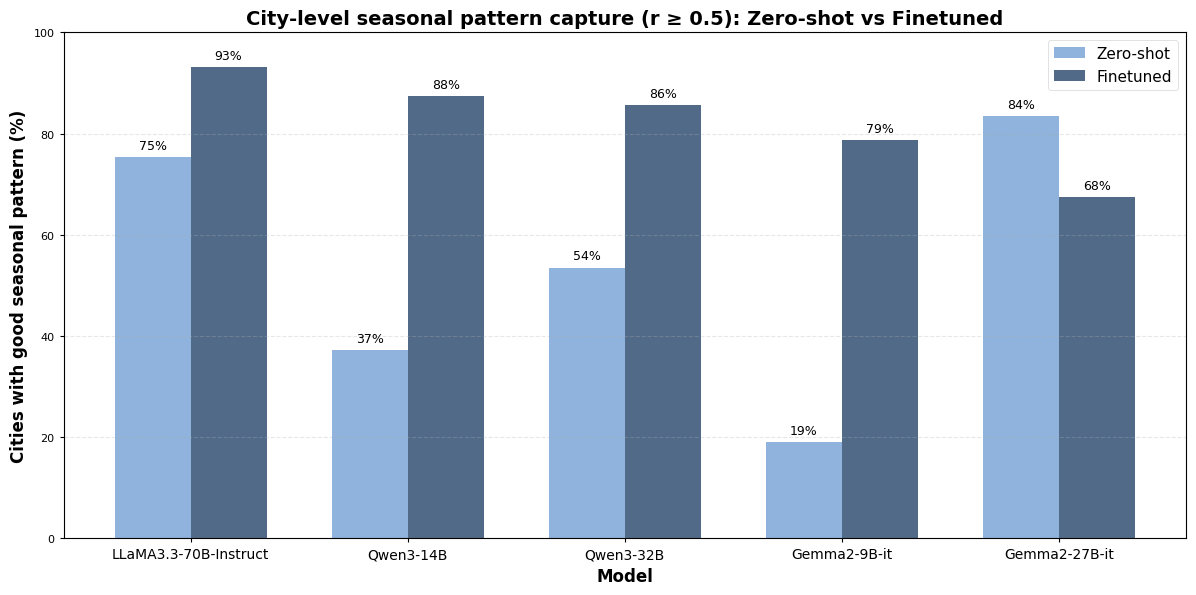

In [14]:
# ---- grouped bar plot: zero-shot vs finetuned ----
x = np.arange(len(combined))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars_zero = ax.bar(x - width/2, combined['pct_zero'], width,
                   label='Zero-shot', color='#7BA6D6', alpha=0.85)
bars_fine = ax.bar(x + width/2, combined['pct_fine'], width,
                   label='Finetuned', color='#3D5A7B', alpha=0.9)

ax.set_ylabel('Cities with good seasonal pattern (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('City-level seasonal pattern capture (r ≥ 0.5): Zero-shot vs Finetuned',
             fontsize=14, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(combined['model'], fontsize=10)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=11, frameon=True)

for bar, value in zip(bars_zero, combined['pct_zero']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{value:.0f}%", ha='center', va='bottom', fontsize=9)

for bar, value in zip(bars_fine, combined['pct_fine']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f"{value:.0f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

                   model  n_cities_zero   pct_zero  n_cities_fine  pct_fine
2  LLaMA3.3-70B-Instruct            199  75.376884            160    93.125
3              Qwen3-14B            177  37.288136            160    87.500
4              Qwen3-32B            170  53.529412            160    85.625
1           Gemma2-9B-it            200  19.000000            160    78.750
0          Gemma2-27B-it            200  83.500000            160    67.500


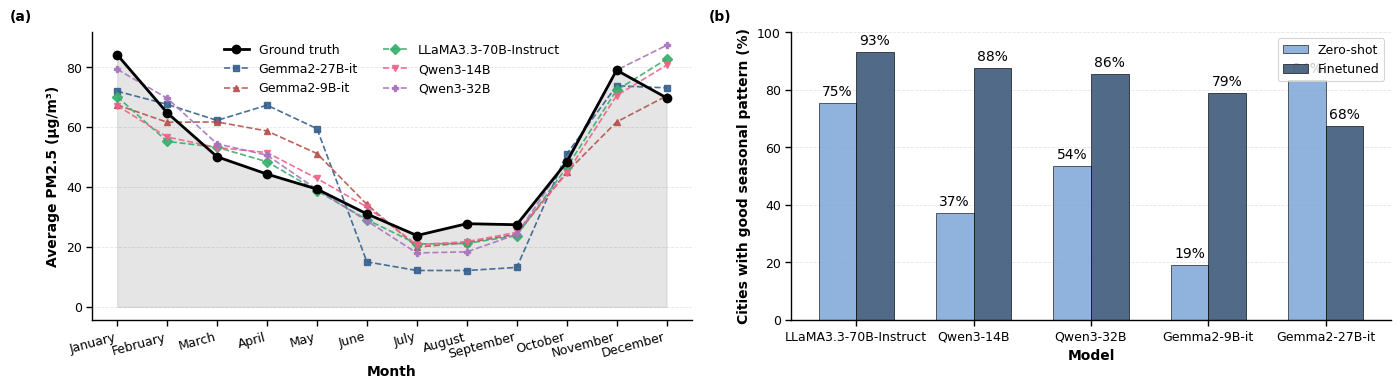

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Use full month names for consistent X axis
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']
x = np.arange(len(month_order))

# Compute GT monthly means
gt_month_map = dict(zip(range(1, 13), month_order))
ground_truth_df['month_name'] = ground_truth_df['month'].map(gt_month_map)
gt_monthly = ground_truth_df.groupby('month_name')['ground_truth_pm25'].mean().reindex(month_order)


finetuned_mon_means = {}  # model_name -> (mean by month)
for df,_, name in finetuned_models:
    # Ensure correct month column as int 1-12 and "month_name" to map to month_order
    if 'month' in df.columns:
        df['month'] = df['month'].astype(int)
    df['month_name'] = df['month'].map(gt_month_map)
    finetuned_mon_means[name] = df.groupby('month_name')['pm2.5_predicted'].mean().reindex(month_order)
# --------- combined seasonal figure: (c) and (d) ----------
latexify(fig_width=14, fig_height=4, columns=2)  # full-page width

fig, (ax_line, ax_bar) = plt.subplots(1, 2)

# ===== (c) Line plot: seasonal pattern tracking =====
ax = ax_line

ax.plot(x, gt_monthly.values, marker='o', linewidth=2.0, markersize=6,
        label='Ground truth', color='black', linestyle='-', zorder=10)
ax.fill_between(x, 0, gt_monthly.values, alpha=0.10, color='black', zorder=1)

finetuned_colors = ['#35618f', '#b5524e', '#35af6b', '#ef638b', '#aa72c0']
markers = ['s', '^', 'D', 'v', 'P', 'h']

for i, name in enumerate(finetuned_mon_means.keys()):
    ax.plot(x, finetuned_mon_means[name].values,
            marker=markers[i % len(markers)],
            linewidth=1.2, markersize=5,
            label=name,
            color=finetuned_colors[i % len(finetuned_colors)],
            alpha=0.9, linestyle='--',)

ax.set_ylabel('Average PM2.5 (µg/m³)', fontweight='bold', labelpad=4)
ax.set_xlabel('Month', fontweight='bold', labelpad=3)
ax.set_xticks(x)
ax.set_xticklabels(month_order, rotation=15, ha='right')
ax.set_xlim(-0.5, len(month_order) - 0.5)

# ax.legend(fontsize=7, frameon=True, loc='upper right', ncol=1)
ax.legend(
    frameon=False,
    loc='upper center',
    # bbox_to_anchor=(0.70, 0.98),   # x closer to centre
    ncol=2
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)

ax.text(-0.10, 1.03, '(a)', transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_city_seasonality(model_df, pred_col, gt_df=ground_truth_df, threshold=0.5):
    df = model_df.copy()
    gt = gt_df.copy()

    # Standardize city/state
    for col in ['city', 'state']:
        if col in df.columns:
            df[col] = df[col].str.lower().str.strip()
        if col in gt.columns:
            gt[col] = gt[col].str.lower().str.strip()

    # Map month names → numbers if needed
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    if df['month'].dtype == object:
        df['month'] = df['month'].map(month_map)

    # Ensure month/year numeric
    df['month'] = df['month'].astype(int)
    df['year'] = df['year'].astype(int)
    gt['month'] = gt['month'].astype(int)
    gt['year'] = gt['year'].astype(int)

    # Merge
    merged = pd.merge(
        df,
        gt[['city', 'state', 'year', 'month', 'ground_truth_pm25']],
        on=['city', 'state', 'year', 'month'],
        how='inner'
    )

    city_corrs = []
    month_order = ['january', 'february', 'march', 'april', 'may', 'june',
                   'july', 'august', 'september', 'october', 'november', 'december']

    # month_name
    if 'month_name' not in merged.columns:
        merged['month_name'] = merged['month'].apply(lambda x: month_order[x - 1])
    else:
        merged['month_name'] = merged['month_name'].str.lower()

    # Correlations
    for city, g in merged.groupby('city'):
        g_month = (
            g.groupby('month_name')[[pred_col, 'ground_truth_pm25']]
             .mean()
             .reindex(month_order)
        ).dropna()

        if len(g_month) >= 8:
            pred_vals = g_month[pred_col].values
            gt_vals = g_month['ground_truth_pm25'].values
            if np.std(pred_vals) > 0 and np.std(gt_vals) > 0:
                r = np.corrcoef(pred_vals, gt_vals)[0, 1]
                city_corrs.append(r)

    city_corrs = np.array(city_corrs)
    n_cities = len(city_corrs)
    pct_good = 100 * np.sum(city_corrs >= threshold) / n_cities if n_cities > 0 else 0
    return pct_good, n_cities

# ---- compute for zero-shot and finetuned ----
seasonal_stats_zero = []
seasonal_stats_fine = []

for df, pred_col, name in zero_shot_models:
    pct, n = compute_city_seasonality(df, pred_col)
    seasonal_stats_zero.append({'model': name, 'n_cities_zero': n, 'pct_zero': pct})

for df, pred_col, name in finetuned_models:
    pct, n = compute_city_seasonality(df, pred_col)
    seasonal_stats_fine.append({'model': name, 'n_cities_fine': n, 'pct_fine': pct})

zero_df = pd.DataFrame(seasonal_stats_zero)
fine_df = pd.DataFrame(seasonal_stats_fine)

combined = pd.merge(zero_df, fine_df, on='model', how='inner')
combined = combined.sort_values('pct_fine', ascending=False)
print(combined)

# ===== (d) Grouped bar plot: city-level seasonal capture =====
ax = ax_bar

x_bar = np.arange(len(combined))
width = 0.32

bars_zero = ax.bar(x_bar - width/2, combined['pct_zero'], width,
                   label='Zero-shot', color='#7BA6D6', alpha=0.85,
                   edgecolor='black', linewidth=0.5)
bars_fine = ax.bar(x_bar + width/2, combined['pct_fine'], width,
                   label='Finetuned', color='#3D5A7B', alpha=0.9,
                   edgecolor='black', linewidth=0.5)

ax.set_ylabel('Cities with good seasonal pattern (%)',
              fontweight='bold')
ax.set_xlabel('Model', fontweight='bold')
ax.set_xticks(x_bar)
ax.set_xticklabels(combined['model'])
ax.set_ylim(0, 100)

ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.legend(frameon=True, loc='upper right')

for bar, value in zip(bars_zero, combined['pct_zero']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f"{value:.0f}%", ha='center', va='bottom')
for bar, value in zip(bars_fine, combined['pct_fine']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f"{value:.0f}%", ha='center', va='bottom')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)

ax.text(-0.10, 1.03, '(b)', transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

plt.tight_layout(w_pad=2.0)
plt.savefig('finetune_seasonal_trend.pdf', dpi=300,
            bbox_inches='tight', format='pdf')
plt.show()

#### Media bias

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

wiki_news_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ2/Dataset/Wiki_News_Data.csv")
for col in ['city', 'state']:
    wiki_news_df[col] = wiki_news_df[col].astype(str).str.strip().str.lower()

# Load all finetuned LLM prediction files and normalize columns

model_dfs = {}
for path, name in model_files:
    df = pd.read_csv(path)
    for col in ['city', 'state']:
        df[col] = df[col].astype(str).str.strip().str.lower()
    if 'year' not in df:
        df['year'] = pd.to_datetime(df['YearMonth']).dt.year
    if 'month' in df and df['month'].dtype == 'object':
        df['month'] = pd.to_datetime(df['month'], errors='coerce').dt.month.fillna(df['month']).astype(int)
    elif 'month' not in df:
        df['month'] = pd.to_datetime(df['YearMonth']).dt.month
    else:
        df['month'] = df['month'].astype(int)
    model_dfs[name] = df

In [30]:
def build_news_metrics(
    model_dfs,
    wiki_news_df,
    news_count_threshold=0,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    rows = []

    for model_name, model_df in model_dfs.items():
        merged = pd.merge(
            model_df,
            wiki_news_df,
            on=["city", "state"],
            how="left",
        )
        merged["media_count"] = merged["media_count"].fillna(0)

        merged = merged.dropna(subset=["pm2.5_actual", "pm2.5_predicted"])

        merged["pm2.5"] = merged["pm2.5_predicted"]
        merged["ground_truth_pm25"] = merged["pm2.5_actual"]

        merged["Media Group"] = np.where(
            merged["media_count"] > news_count_threshold,
            "High News",
            "Low News",
        )

        for group, gdf in merged.groupby("Media Group"):
            m = compute_metrics(
                gdf,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m["Model"] = model_name
            m["Group"] = group
            rows.append(m)

    metrics_df = pd.DataFrame(rows)

    # enforce ordering
    metrics_df["Model"] = pd.Categorical(
        metrics_df["Model"],
        categories=list(model_dfs.keys()),
        ordered=True,
    )
    metrics_df["Group"] = pd.Categorical(
        metrics_df["Group"],
        categories=["High News", "Low News"],
        ordered=True,
    )

    return metrics_df


In [31]:
news_metrics_df = build_news_metrics(
    model_dfs,
    wiki_news_df,
    news_count_threshold=0,
    n_bootstrap=1000,
    alpha=0.05,
)


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_news_mae_uncertainty(
    metrics_df,
    city_counts,
    err_type="se",         # "se", "param_ci", "boot_ci"
    save_path=None,
    use_latexify=True,
    columns=2,
    fig_width=None,
    fig_height=None,
):
    # apply LaTeX-style rcParams
    if use_latexify:
        latexify(fig_width=fig_width, fig_height=fig_height, columns=columns)

    df = metrics_df.copy()

    groups = ["High News", "Low News"]
    colors = {
        "High News": "#35618f",
        "Low News": "#b5524e",
    }

    legend_name = {
        "High News": "With news",
        "Low News": "Without news",
    }


    # model order from categorical if present
    if hasattr(df["Model"], "cat"):
        model_order = list(df["Model"].cat.categories)
    else:
        model_order = list(df["Model"].unique())

    x = np.arange(len(model_order))
    width = 0.7 / len(groups)

    def get_error(g):
        mean = g["MAE"].to_numpy()
        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            return mean - g["MAE_ci_low_param"], g["MAE_ci_high_param"] - mean
        elif err_type == "boot_ci":
            return mean - g["MAE_ci_low_boot"], g["MAE_ci_high_boot"] - mean
        else:
            raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")

    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    fig, ax = plt.subplots()  # figsize comes from latexify

    for i, group in enumerate(groups):
        g = df[df["Group"] == group].set_index("Model").loc[model_order]

        xpos = x - width / 2 + i * width
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            # label=f"{group} (n={city_counts[group]})",
            label=f"{legend_name[group]} (n={city_counts[group]})",
            color=colors[group],
            edgecolor="black",
            linewidth=1.0,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
        )

        for xp, h, eh in zip(xpos, heights, err_high):
            ax.text(
                xp,
                h + eh + 0.03 * y_max,
                f"{h:.1f}",
                ha="center",
                fontsize=9,
            )

    # diff annotation (Low − High)
    pivot = df.pivot(index="Model", columns="Group", values="MAE")
    for i, m in enumerate(model_order):
        diff = pivot.loc[m, "Low News"] - pivot.loc[m, "High News"]
        ax.text(
            i,
            y_max * 0.04,
            f"Diff:{diff:+.1f}",
            ha="center",
            color="white",
            fontsize=9,
            fontweight="bold",
        )

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_xlabel("Model")
    ax.set_ylim(0, y_max * 1.25)

    ax.legend(frameon=False, loc="upper right")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_axisbelow(True)

    ax.text(
        -0.03, 1.2, "(a)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        fontweight="bold"
    )

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


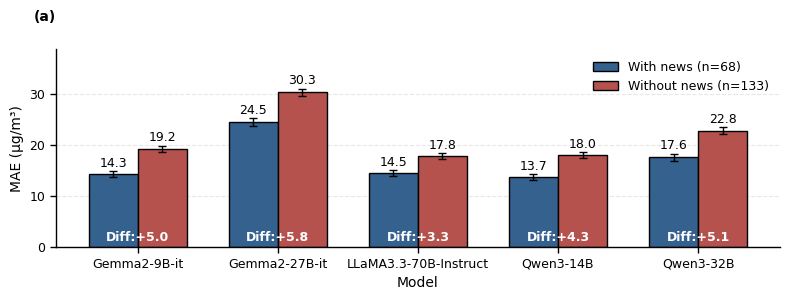

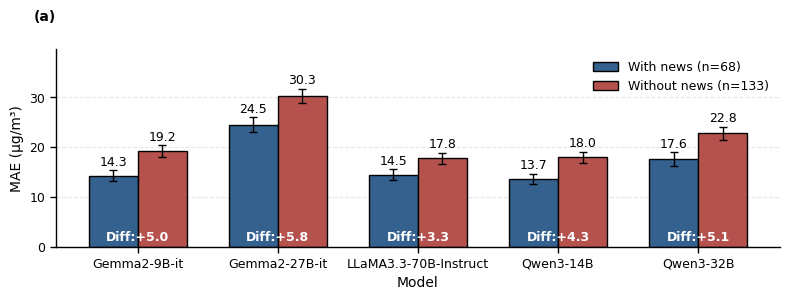

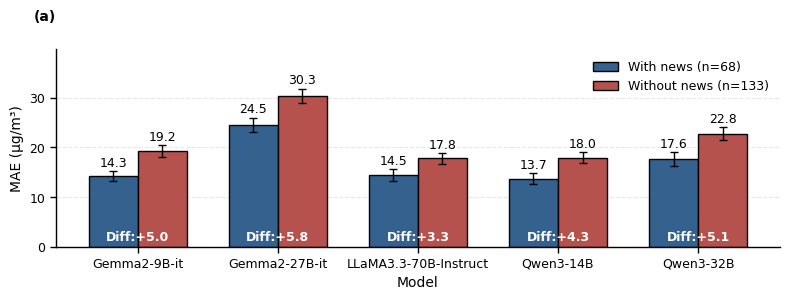

In [32]:
# city counts
n_high = wiki_news_df[wiki_news_df["media_count"] > 0]["city"].nunique()
n_low  = wiki_news_df[wiki_news_df["media_count"] == 0]["city"].nunique()
city_counts = {"High News": n_high, "Low News": n_low}

latexify(columns=2, fig_width=8, fig_height=3.2)

plot_news_mae_uncertainty(news_metrics_df, city_counts, err_type="se", use_latexify=False)
plot_news_mae_uncertainty(news_metrics_df, city_counts, err_type="param_ci", use_latexify=False)
plot_news_mae_uncertainty(news_metrics_df, city_counts, err_type="boot_ci", use_latexify=False,save_path="media_finetune_mae_boot_ci.pdf")


#### Socioeconomic bias

##### City Tier based

In [31]:
city_tier_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ3/Dataset/city_tire.csv")
city_tier_df['city'] = city_tier_df['city'].astype(str).str.strip().str.lower()
city_tier_df['Tier'] = city_tier_df['Tier'].astype(str).str.strip().str.lower()  # 'tier1','tier2','tier3'


In [32]:
import numpy as np
import pandas as pd

def build_tier_metrics_finetune(
    model_dfs,
    city_tier_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    model_dfs: {model_name: df}, with columns 'city', 'pm2.5_actual', 'pm2.5_predicted'
    city_tier_df: has columns 'city', 'Tier' (tier1/tier2/tier3, lowercase)
    Uses your global compute_metrics (gt: 'ground_truth_pm25', pred: 'pm2.5').
    Returns:
        tier_metrics_df, tier_city_counts
    """
    city_tier = city_tier_df.copy()
    city_tier["city"] = city_tier["city"].astype(str).str.strip().str.lower()
    city_tier["Tier"] = city_tier["Tier"].astype(str).str.strip().str.lower()

    tiers = ["tier1", "tier2", "tier3"]
    rows = []

    # ---- compute metrics per (Model, Tier) ----
    for model_name, df in model_dfs.items():
        df = df.copy()
        df["city"] = df["city"].astype(str).str.strip().str.lower()

        merged = pd.merge(df, city_tier[["city", "Tier"]], on="city", how="left")

        for tier in tiers:
            tier_df = merged[merged["Tier"] == tier].copy()
            if tier_df.empty:
                continue

            # rename cols so they match compute_metrics expectations
            tmp = tier_df.rename(
                columns={
                    "pm2.5_actual": "ground_truth_pm25",
                    "pm2.5_predicted": "pm2.5",
                }
            )

            m = compute_metrics(
                tmp,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m["Model"] = model_name
            m["Tier"] = f"Tier {tier[-1]}"  # tier1 -> "Tier 1"
            rows.append(m)

    tier_metrics_df = pd.DataFrame(rows)

    # enforce model & tier ordering
    tier_metrics_df["Model"] = pd.Categorical(
        tier_metrics_df["Model"],
        categories=list(model_dfs.keys()),
        ordered=True,
    )
    tier_metrics_df["Tier"] = pd.Categorical(
        tier_metrics_df["Tier"],
        categories=["Tier 1", "Tier 2", "Tier 3"],
        ordered=True,
    )
    tier_metrics_df = tier_metrics_df.sort_values(["Model", "Tier"])

    # ---- city counts for legend ----
    def city_count_for_tier(tier_code):
        cities = set()
        for df in model_dfs.values():
            df_ = df.copy()
            df_["city"] = df_["city"].astype(str).str.strip().str.lower()
            merged = pd.merge(df_, city_tier[["city", "Tier"]], on="city", how="left")
            cities.update(merged[merged["Tier"] == tier_code]["city"].unique())
        return len(cities)

    tier_city_counts = {
        "Tier 1": city_count_for_tier("tier1"),
        "Tier 2": city_count_for_tier("tier2"),
        "Tier 3": city_count_for_tier("tier3"),
    }

    return tier_metrics_df, tier_city_counts

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tier_mae_uncertainty_finetune(
    tier_metrics_df,
    tier_city_counts=None,
    err_type="se",          # "se", "param_ci", "boot_ci"
    save_path=None,
    use_latexify=True,
    columns=2,
    fig_width=None,
    fig_height=None,
):
    """
    Grouped bar plot:
      x-axis: Model
      bars:   Tier 1 / 2 / 3
      yerr:   chosen uncertainty type from compute_metrics.
    """

    if use_latexify:
        latexify(fig_width=fig_width, fig_height=fig_height, columns=columns)

    df = tier_metrics_df.copy()

    # groups (tiers) and colors
    if hasattr(df["Tier"], "cat"):
        groups = list(df["Tier"].cat.categories)
    else:
        groups = sorted(df["Tier"].unique())

    colors = {
        "Tier 1": "#2E5F8C",
        "Tier 2": "#7A9BBF",
        "Tier 3": "#A94E4E",
    }

    # model order
    if hasattr(df["Model"], "cat"):
        model_order = list(df["Model"].cat.categories)
    else:
        model_order = list(df["Model"].unique())

    x = np.arange(len(model_order))
    width = 0.8 / len(groups)

    # auto city counts if not provided
    if tier_city_counts is None:
        tier_city_counts = {g: np.nan for g in groups}

    legend_labels = {
        g: f"{g} (n={tier_city_counts.get(g, np.nan)})" for g in groups
    }

    def get_error(g):
        mean = g["MAE"].to_numpy()
        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")
        return mean - low, high - mean

    # y-axis upper bound
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    y_offset = 0.03 * y_max

    fig, ax = plt.subplots()

    # ----- draw grouped bars -----
    for i_group, group in enumerate(groups):
        g = df[df["Tier"] == group].set_index("Model").loc[model_order]

        xpos = x - 0.4 + i_group * width + width / 2
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            label=legend_labels[group],
            color=colors.get(group, "#999999"),
            edgecolor="black",
            linewidth=1.0,
            zorder=3,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
            zorder=5,
        )

        # numeric labels
        for xp, h, eh in zip(xpos, heights, err_high):
            ax.text(
                xp,
                h + eh + y_offset,
                f"{h:.1f}",
                ha="center",
                fontsize=9,
            )

    # axes, labels, legend
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_ylim(0, y_max * 1.25)

    ax.legend(frameon=False, loc="upper right")
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_axisbelow(True)

    ax.text(
        -0.03, 1.1, "(b)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        fontweight="bold"
    )

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", format="pdf")
    plt.show()


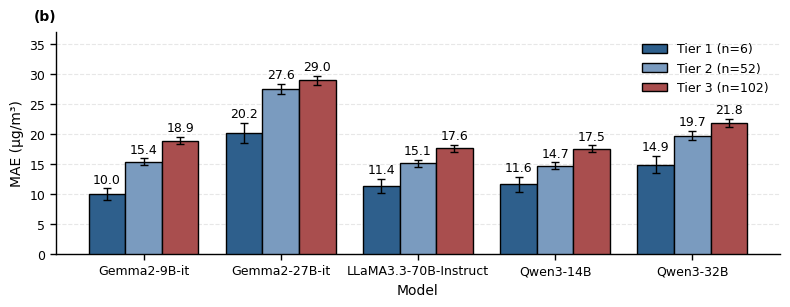

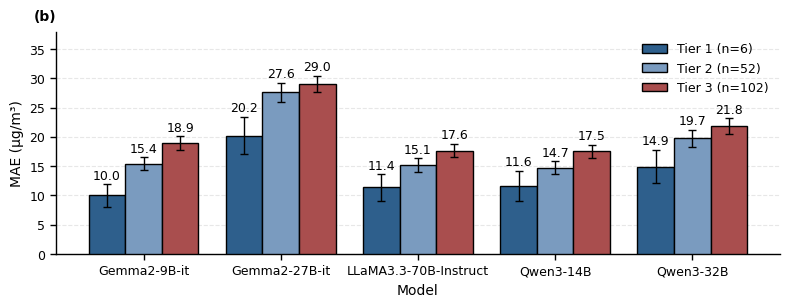

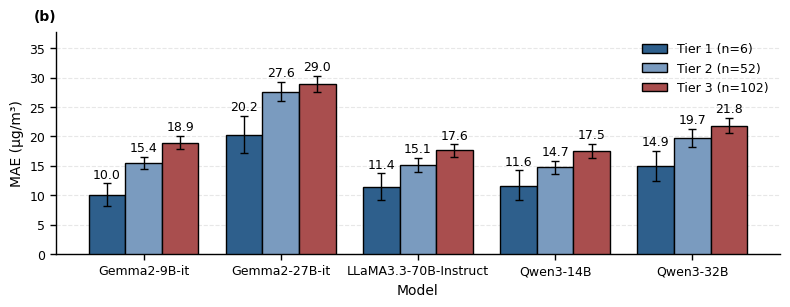

In [80]:
# 1) build metrics from your fine-tuned models
tier_metrics_df, tier_city_counts = build_tier_metrics_finetune(
    model_dfs,
    city_tier_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

# 2) set LaTeX style once
latexify(columns=2, fig_width=8,fig_height=3.2)

# 3a) MAE ± SE
plot_tier_mae_uncertainty_finetune(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="se",
    use_latexify=False,       
    # save_path="tier_finetune_mae_se.pdf",
)

# 3b) MAE with parametric 95% CI
plot_tier_mae_uncertainty_finetune(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="param_ci",
    use_latexify=False,
    # save_path="tier_finetune_mae_param_ci.pdf",
)

# 3c) MAE with bootstrap 95% CI
plot_tier_mae_uncertainty_finetune(
    tier_metrics_df,
    tier_city_counts=tier_city_counts,
    err_type="boot_ci",
    use_latexify=False,
    save_path="tier_finetune_mae_boot_ci.pdf",
)

##### MPI based

In [41]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---- 1. Read MPI reference and fine-tuned models ----

mpi_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ3/Dataset/mpi_2023.csv")
mpi_df["state"] = mpi_df["state"].str.lower().str.strip()
mpi_df["district"] = mpi_df["district"].str.lower().str.strip()

model_dfs = {}
for path, name in model_files:
    df = pd.read_csv(path)
    df['city'] = df['city'].astype(str).str.strip().str.lower()
    df['state'] = df['state'].astype(str).str.strip().str.lower()
    model_dfs[name] = df

# ---- 2. Fuzzy matching for MPI ----

def get_mpi(row):
    city = str(row["city"]).lower().strip()
    state = str(row["state"]).lower().strip()
    candidates = mpi_df[mpi_df["state"] == state]
    if candidates.empty:
        return np.nan
    candidates = candidates.copy()
    # compute fuzzy match score between district and city name
    candidates["score"] = candidates["district"].apply(lambda d: fuzz.token_sort_ratio(d, city))
    best_match = candidates.loc[candidates["score"].idxmax()]
    if best_match["score"] >= 80:
        return best_match["mpi"]
    else:
        return np.nan

# Combine all model predictions into one DataFrame
model_list = []
for name, df in model_dfs.items():
    tmp = df.copy()
    tmp["model"] = name
    model_list.append(tmp)
all_models_df = pd.concat(model_list, ignore_index=True)

# Expect columns: 'city', 'state', 'pm2.5_actual', 'pm2.5_predicted', 'model'
tqdm.pandas()
all_models_df["mpi"] = all_models_df.progress_apply(get_mpi, axis=1)

# Drop rows where mpi could not be matched
merged_df = all_models_df.dropna(subset=["mpi"]).copy()

100%|██████████| 9660/9660 [00:12<00:00, 761.91it/s]


In [43]:
# ---- 3. Split by median MPI threshold ----

median_mpi = merged_df["mpi"].median()
merged_df["mpi_group"] = np.where(merged_df["mpi"] < median_mpi, "Low MPI", "High MPI")

In [39]:
import numpy as np
import pandas as pd

def build_mpi_metrics_finetune(
    merged_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    merged_df: output of your MPI matching step, with columns:
        - 'model'
        - 'mpi_group' in {'Low MPI','High MPI'}
        - 'pm2.5_actual'
        - 'pm2.5_predicted'
        - 'city'
    Uses global compute_metrics (expects 'ground_truth_pm25' and 'pm2.5').
    Returns:
        mpi_metrics_df, mpi_city_counts
    """

    df = merged_df.copy()

    # Ensure clean labels
    df["mpi_group"] = df["mpi_group"].astype(str)

    # city counts per group (for legend)
    mpi_city_counts = (
        df.groupby("mpi_group")["city"]
        .nunique()
        .reindex(["Low MPI", "High MPI"])
        .to_dict()
    )

    rows = []
    models = df["model"].unique().tolist()
    groups = ["Low MPI", "High MPI"]

    for model in models:
        for group in groups:
            sub = df[(df["model"] == model) & (df["mpi_group"] == group)].copy()
            if sub.empty:
                continue

            # rename columns to match compute_metrics
            tmp = sub.rename(
                columns={
                    "pm2.5_actual": "ground_truth_pm25",
                    "pm2.5_predicted": "pm2.5",
                }
            )

            m = compute_metrics(
                tmp,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m["Model"] = model
            m["MPI Group"] = group
            rows.append(m)

    mpi_metrics_df = pd.DataFrame(rows)

    # enforce nice ordering
    mpi_metrics_df["Model"] = pd.Categorical(
        mpi_metrics_df["Model"],
        categories=models,
        ordered=True,
    )
    mpi_metrics_df["MPI Group"] = pd.Categorical(
        mpi_metrics_df["MPI Group"],
        categories=["Low MPI", "High MPI"],
        ordered=True,
    )

    mpi_metrics_df = mpi_metrics_df.sort_values(["Model", "MPI Group"])

    return mpi_metrics_df, mpi_city_counts


In [44]:
mpi_metrics_df, mpi_city_counts = build_mpi_metrics_finetune(
    merged_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpi_mae_uncertainty_finetune(
    mpi_metrics_df,
    mpi_city_counts=None,
    err_type="se",      # "se", "param_ci", "boot_ci"
    save_path=None,
    use_latexify=True,
    columns=2,
    fig_width=None,
    fig_height=None,
):
    """
    Grouped bar plot:
      x-axis: Model
      bars:   Low MPI vs High MPI
      yerr:   chosen uncertainty type from compute_metrics.
    """

    if use_latexify:
        latexify(fig_width=fig_width, fig_height=fig_height, columns=columns)

    df = mpi_metrics_df.copy()

    groups = ["Low MPI", "High MPI"]
    colors = {
        "Low MPI": "#3D5A7B",
        "High MPI": "#A94E4E",
    }

    # model order
    if hasattr(df["Model"], "cat"):
        model_order = list(df["Model"].cat.categories)
    else:
        model_order = list(df["Model"].unique())

    x = np.arange(len(model_order))
    width = 0.7 / len(groups)

    # city counts for legend
    if mpi_city_counts is None:
        mpi_city_counts = {g: np.nan for g in groups}

    legend_labels = {
        g: f"{g} (n={mpi_city_counts.get(g, np.nan)})" for g in groups
    }

    def get_error(g):
        mean = g["MAE"].to_numpy()
        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")
        return mean - low, high - mean

    # y-axis upper bound
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    y_offset = 0.03 * y_max

    fig, ax = plt.subplots()

    # ----- bars + error bars -----
    for i_group, group in enumerate(groups):
        g = df[df["MPI Group"] == group].set_index("Model").loc[model_order]

        xpos = x - width / 2 + i_group * width
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            label=legend_labels[group],
            color=colors[group],
            edgecolor="black",
            linewidth=1.0,
            zorder=3,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
            zorder=5,
        )

        # numeric labels above bars
        for xp, h, eh in zip(xpos, heights, err_high):
            ax.text(
                xp,
                h + eh + y_offset,
                f"{h:.1f}",
                ha="center",
                fontsize=9,
            )

    # ----- diff annotation (High − Low) -----
    pivot = df.pivot(index="Model", columns="MPI Group", values="MAE")
    for i, m in enumerate(model_order):
        if "Low MPI" in pivot.columns and "High MPI" in pivot.columns:
            diff = pivot.loc[m, "High MPI"] - pivot.loc[m, "Low MPI"]
            ax.text(
                i,
                y_max * 0.04,
                f"Diff:{diff:+.1f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
                fontweight="bold",
            )

    # axes + styling
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_xlabel("Model")
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_ylim(0, y_max * 1.25)

    ax.text(
        -0.03, 1.2, "(c)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        fontweight="bold"
    )

    ax.legend(frameon=False, loc="upper right")
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_axisbelow(True)

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", format="pdf")
    plt.show()


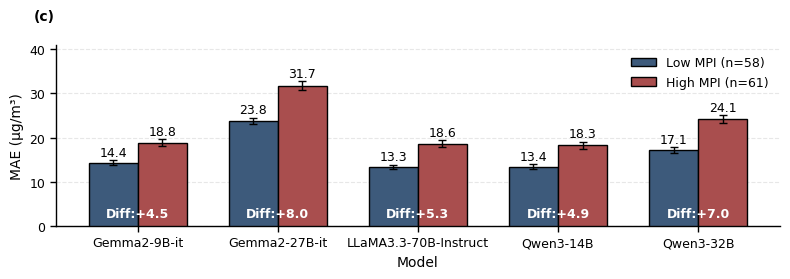

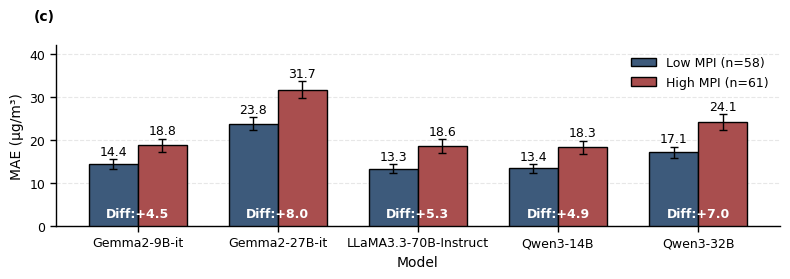

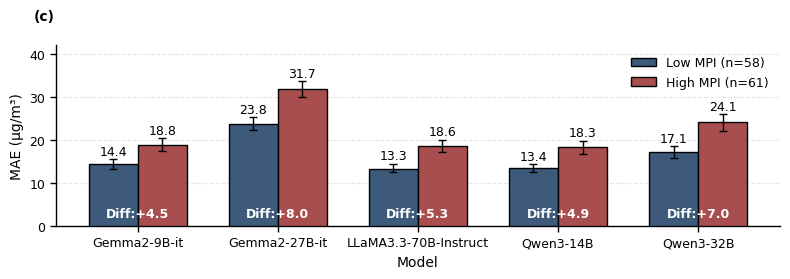

In [72]:
# build metrics once
mpi_metrics_df, mpi_city_counts = build_mpi_metrics_finetune(
    merged_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

# LaTeX RC setup once
latexify(columns=2, fig_width=8,fig_height=3)

# 1) SE
plot_mpi_mae_uncertainty_finetune(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="se",
    use_latexify=False,
    # save_path="mpi_finetune_mae_se.pdf",
)

# 2) Parametric 95% CI
plot_mpi_mae_uncertainty_finetune(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="param_ci",
    use_latexify=False,
    # save_path="mpi_finetune_mae_param_ci.pdf",
)

# 3) Bootstrap 95% CI
plot_mpi_mae_uncertainty_finetune(
    mpi_metrics_df,
    mpi_city_counts=mpi_city_counts,
    err_type="boot_ci",
    use_latexify=False,
    save_path="mpi_finetune_mae_boot_ci.pdf",
)


#### Fine tune predictions VS Ground Truth

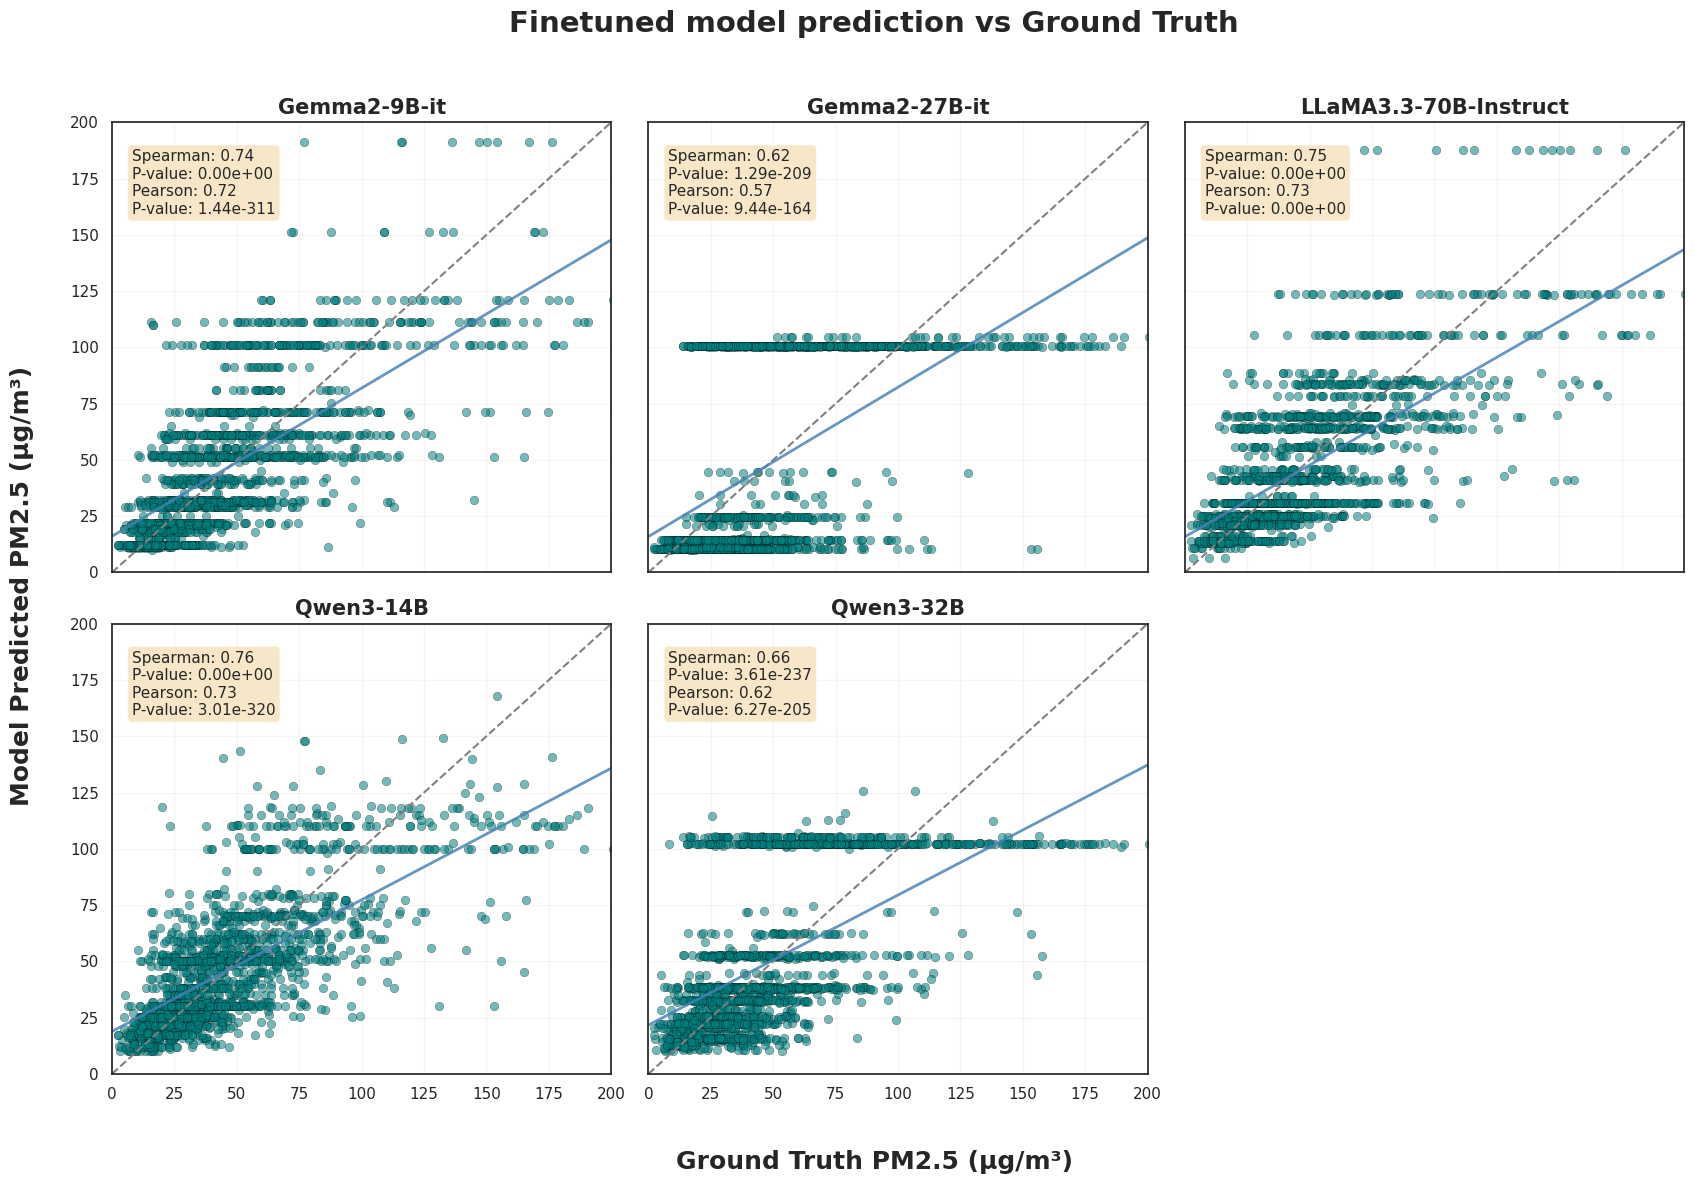

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


model_data = []
for path, name in model_files:
    df = pd.read_csv(path)
    df['city'] = df['city'].astype(str).str.strip().str.lower()
    df['state'] = df['state'].astype(str).str.strip().str.lower()
    # Optional: convert 'pm2.5_actual'/'pm2.5_predicted' to floats if needed
    model_data.append((df, name))

# --- 2. Plotting Grid ---

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (model_df, model_name) in zip(axes, model_data):
    # Use only rows with valid actual/predictions
    valid = (~model_df['pm2.5_actual'].isna()) & (~model_df['pm2.5_predicted'].isna())
    y_true = model_df.loc[valid, 'pm2.5_actual'].values
    y_pred = model_df.loc[valid, 'pm2.5_predicted'].values

    ax.scatter(y_true, y_pred, c='teal', alpha=0.55, s=38, edgecolor='black', linewidth=0.3)
    ax.plot([0, 200], [0, 200], linestyle='--', color='gray', linewidth=1.5, label='Ideal Match')

    # Regression line and stats
    if len(y_true) > 1:
        z = np.polyfit(y_true, y_pred, 1)
        p = np.poly1d(z)
        ax.plot([0, 200], [p(0), p(200)], color='steelblue', linewidth=2, alpha=0.83)
        pearson_corr, pearson_p = pearsonr(y_true, y_pred)
        spearman_corr, spearman_p = spearmanr(y_true, y_pred)
        textstr = (f"Spearman: {spearman_corr:.2f}\nP-value: {spearman_p:.2e}\n"
                   f"Pearson: {pearson_corr:.2f}\nP-value: {pearson_p:.2e}")
        ax.text(0.04, 0.94, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.72))
    ax.set_title(model_name, fontsize=15, fontweight='bold')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    ax.grid(alpha=0.20)

# Remove unused axes if fewer than 6 models
for ax in axes[len(model_data):]:
    fig.delaxes(ax)

fig.supxlabel('Ground Truth PM2.5 (μg/m³)', fontsize=18, fontweight='bold')
fig.supylabel('Model Predicted PM2.5 (μg/m³)', fontsize=18, fontweight='bold')
fig.suptitle('Finetuned model prediction vs Ground Truth', fontsize=21, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0.02, 0.02, 0.96, 0.96])
plt.show()

#### Geographic bias

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
gt_df['city'] = gt_df['city'].astype(str).str.strip().str.lower()
gt_df['state'] = gt_df['state'].astype(str).str.strip().str.lower()
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5', 'latitude', 'longitude']].rename(columns={'PM2.5': 'ground_truth_pm25'})

# Convert month names to month numbers for merges
month_lookup = {name: num for num, name in enumerate(calendar.month_name) if name}
gt_df['month_num'] = gt_df['month'].map(month_lookup)

# ---------- 2. Region mapping ----------
region_mapping = {
    'north': ['uttar pradesh', 'haryana', 'punjab', 'himachal pradesh',
              'uttarakhand', 'jammu and kashmir', 'chandigarh', 'delhi'],
    'south': ['tamil nadu', 'karnataka', 'andhra pradesh', 'telangana',
              'kerala', 'puducherry'],
    'east': ['west bengal', 'bihar', 'odisha'],
    'west': ['maharashtra', 'gujarat', 'rajasthan'],
    'central': ['madhya pradesh', 'chhattisgarh'],
    'northeast': ['tripura', 'mizoram', 'assam', 'sikkim', 'nagaland',
                  'arunachal pradesh', 'meghalaya']
}
def get_region(state):
    state = str(state).lower().strip()
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'other'
gt_df['region'] = gt_df['state'].apply(get_region)

model_dfs = {}
for path, name in model_files:
    df = pd.read_csv(path)
    # normalize
    df['city'] = df['city'].astype(str).str.strip().str.lower()
    df['state'] = df['state'].astype(str).str.strip().str.lower()
    # ensure year/month_num columns exist and are ints
    if 'year' in df.columns:
        df['year'] = df['year'].astype(int)
    if 'month' in df.columns:
        # if month column is numeric or name, convert robustly
        try:
            df['month_num'] = df['month'].astype(int)
        except Exception:
            # try mapping month names
            df['month_num'] = pd.to_datetime(df['month'], errors='coerce').dt.month
    model_dfs[name] = df

In [56]:
import numpy as np
import pandas as pd

def build_region_metrics_finetune(
    model_dfs,
    gt_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    Build region-level MAE + uncertainty per (Region, Model) for fine-tuned models.

    model_dfs: {model_name: df}
        dfs must have columns: 'city','state','year','month_num', and a prediction col
        (one of 'pm2.5_predicted','pm2.5','pm25_predicted','predicted_pm2.5').
    gt_df:
        must have columns: 'city','state','year','month_num','ground_truth_pm25','region'
    Returns:
        region_metrics_df, region_city_counts, region_order
    """

    rows = []

    # ---- find prediction column name per model inside loop ----
    pred_candidates = ["pm2.5_predicted", "pm2.5", "pm25_predicted", "predicted_pm2.5"]

    for model_name, mdf in model_dfs.items():
        df = mdf.copy()
        df["city"] = df["city"].astype(str).str.strip().str.lower()
        df["state"] = df["state"].astype(str).str.strip().str.lower()

        merged = pd.merge(
            df,
            gt_df,
            on=["city", "state", "year", "month_num"],
            how="inner",
        )

        if merged.empty:
            continue

        # ensure region exists
        if "region" not in merged.columns:
            raise KeyError("Column 'region' not found in gt_df/merged; please compute it beforehand.")

        # choose prediction column
        pred_col = None
        for c in pred_candidates:
            if c in merged.columns:
                pred_col = c
                break
        if pred_col is None:
            raise KeyError(
                f"No prediction column found in model {model_name}. "
                f"Expected one of {pred_candidates}"
            )

        merged = merged.dropna(subset=["ground_truth_pm25", pred_col]).copy()
        if merged.empty:
            continue

        # rename to match compute_metrics
        merged = merged.rename(columns={pred_col: "pm2.5"})

        # compute metrics per region
        for region_lower, g in merged.groupby("region"):
            if g.empty:
                continue
            tmp = g.copy()
            tmp["Region"] = region_lower.capitalize()

            metrics = compute_metrics(
                tmp,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            metrics["Model"] = model_name
            metrics["Region"] = region_lower.capitalize()
            rows.append(metrics)

    region_metrics_df = pd.DataFrame(rows)

    if region_metrics_df.empty:
        raise ValueError("region_metrics_df is empty – check merges and prediction columns.")

    # ---- Region ordering: best → worst by average MAE across models ----
    region_means = (
        region_metrics_df.groupby("Region")["MAE"]
        .mean()
        .sort_values()
    )
    region_order = region_means.index.tolist()

    # ---- City counts per region (from gt_df) ----
    gt_tmp = gt_df.copy()
    gt_tmp["Region"] = gt_tmp["region"].str.capitalize()
    region_city_counts = gt_tmp.groupby("Region")["city"].nunique().to_dict()

    # enforce categorical ordering
    region_metrics_df["Region"] = pd.Categorical(
        region_metrics_df["Region"],
        categories=region_order,
        ordered=True,
    )
    region_metrics_df["Model"] = pd.Categorical(
        region_metrics_df["Model"],
        categories=list(model_dfs.keys()),
        ordered=True,
    )

    region_metrics_df = region_metrics_df.sort_values(["Region", "Model"])

    return region_metrics_df, region_city_counts, region_order


In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_region_mae_uncertainty_finetune(
    region_metrics_df,
    region_city_counts,
    region_order=None,
    selected_models=None,
    err_type="se",          # "se", "param_ci", "boot_ci"
    save_path=None,
    use_latexify=True,
    columns=2,
    fig_width=None,
    fig_height=None,
):
    """
    Grouped bar plot:
      x-axis: Region (best → worst)
      bars:   models
      yerr:   SE / param CI / bootstrap CI (from compute_metrics).
    """

    if use_latexify:
        latexify(fig_width=fig_width, fig_height=fig_height, columns=columns)

    df = region_metrics_df.copy()

    # region order
    if region_order is None:
        if hasattr(df["Region"], "cat"):
            region_order = list(df["Region"].cat.categories)
        else:
            region_order = sorted(df["Region"].unique())

    # models
    if selected_models is None:
        if hasattr(df["Model"], "cat"):
            selected_models = list(df["Model"].cat.categories)
        else:
            selected_models = list(df["Model"].unique())
    else:
        selected_models = [m for m in selected_models if m in df["Model"].unique()]

    df = df[df["Model"].isin(selected_models)]

    n_regions = len(region_order)
    n_models = len(selected_models)

    x = np.arange(n_regions)
    bar_width = 0.8 / max(n_models, 1)

    # colors for models
    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                   '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    color_map = {
        model: base_colors[i % len(base_colors)]
        for i, model in enumerate(selected_models)
    }

    # uncertainty
    def get_error(g):
        mean = g["MAE"].to_numpy()
        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")
        return mean - low, high - mean

    # y-axis upper bound
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])
    y_offset = 0.03 * y_max

    fig, ax = plt.subplots()

    # ---- draw grouped bars ----
    for i, model in enumerate(selected_models):
        offset = (i - n_models / 2 + 0.5) * bar_width
        sub = df[df["Model"] == model].set_index("Region").loc[region_order]

        mae_vals = sub["MAE"].to_numpy()
        err_low, err_high = get_error(sub)

        valid = ~np.isnan(mae_vals)
        xpos = x[valid] + offset

        bars = ax.bar(
            xpos,
            mae_vals[valid],
            bar_width,
            label=model,
            color=color_map[model],
            alpha=0.85,
            edgecolor="black",
            linewidth=0.5,
            zorder=3,
        )

        ax.errorbar(
            xpos,
            mae_vals[valid],
            yerr=np.vstack([err_low[valid], err_high[valid]]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=0.9,
            zorder=5,
        )

        # numeric labels above bars
        valid_idx = np.where(valid)[0]
        for j, bar in enumerate(bars):
            idx = valid_idx[j]
            h = mae_vals[idx]
            eh = err_high[idx]
            y_text = h + eh + y_offset
            # ax.text(
            #     bar.get_x() + bar.get_width() / 2.0,
            #     y_text,
            #     f"{h:.1f}",
            #     ha="center",
            #     va="bottom",
            #     fontsize=8,
            # )

    # x labels with region city counts
    region_labels = [
        f"{r}\n(n={region_city_counts.get(r, 0)})" for r in region_order
    ]
    ax.set_xticks(x)
    ax.set_xticklabels(region_labels)

    ax.set_xlabel("Region (Best → Worst Performance)")
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_ylim(0, y_max * 1.20)

    ax.legend(
        fontsize=8,
        ncol=min(3, n_models),
        frameon=False,
        loc="upper left",
    )

    ax.text(
        -0.03, 1.2, "(d)",
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=10,
        fontweight="bold"
    )

    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_axisbelow(True)

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", format="pdf")
    plt.show()


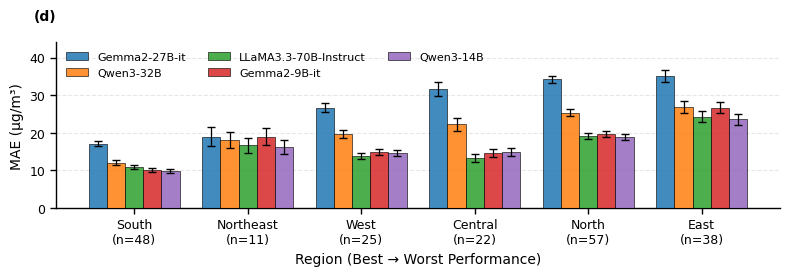

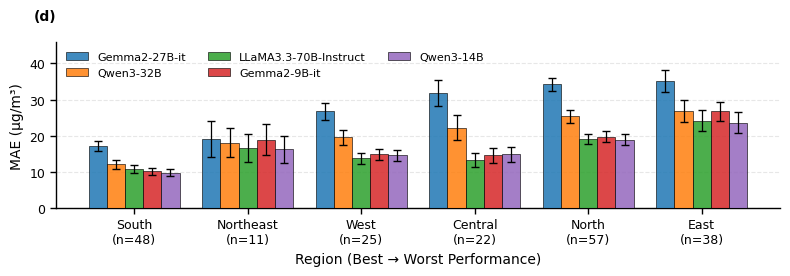

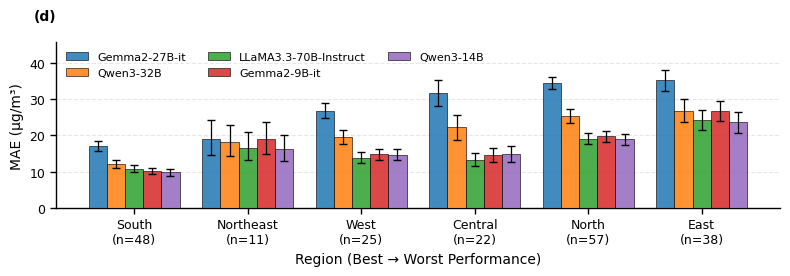

In [85]:
# 1) Build metrics
region_metrics_df, region_city_counts, region_order = build_region_metrics_finetune(
    model_dfs,
    gt_df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)

# 2) Choose models (optional, like your earlier selected_models)
selected_models = [
    "Gemma2-27B-it",
    "Qwen3-32B",
    "LLaMA3.3-70B-Instruct",
    "Gemma2-9B-it",
    "Qwen3-14B",
]
selected_models = [m for m in selected_models if m in region_metrics_df["Model"].unique()]

# 3) LaTeX RC once
latexify(columns=2, fig_width=8, fig_height=3)

# SE
plot_region_mae_uncertainty_finetune(
    region_metrics_df,
    region_city_counts=region_city_counts,
    region_order=region_order,
    selected_models=selected_models,
    err_type="se",
    use_latexify=False,
    # save_path="region_finetune_mae_se.pdf",
)

# Parametric 95% CI
plot_region_mae_uncertainty_finetune(
    region_metrics_df,
    region_city_counts=region_city_counts,
    region_order=region_order,
    selected_models=selected_models,
    err_type="param_ci",
    use_latexify=False,
    # save_path="region_finetune_mae_param_ci.pdf",
)

# Bootstrap 95% CI
plot_region_mae_uncertainty_finetune(
    region_metrics_df,
    region_city_counts=region_city_counts,
    region_order=region_order,
    selected_models=selected_models,
    err_type="boot_ci",
    use_latexify=False,
    save_path="region_finetune_mae_boot_ci.pdf",
)

#### Combined plot

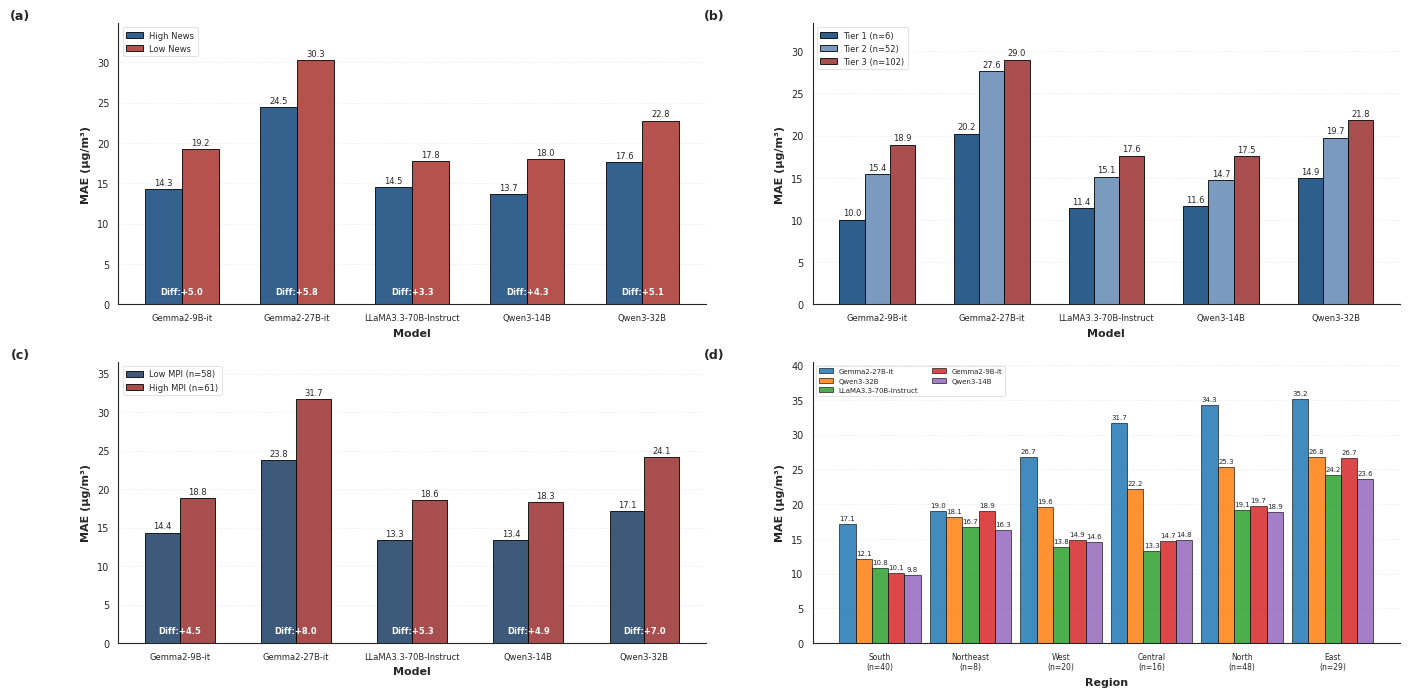

In [40]:
# Apply latexify for 2-column width, taller for 2×2 grid
latexify(fig_width=14, fig_height=7.0, columns=2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 7.0))

# ========== (a) Digital visibility bias (Media Presence) ==========
ax = ax1
df_melted_a = df_melted.copy()  # from your news count analysis
models_a = df_melted_a['Model'].unique()
x_a = np.arange(len(models_a))
width_a = 0.32

high_vals = df_melted_a[df_melted_a['Media Presence Group'] == 'High News'].set_index('Model')['MAE'].reindex(models_a).values
low_vals = df_melted_a[df_melted_a['Media Presence Group'] == 'Low News'].set_index('Model')['MAE'].reindex(models_a).values

ax.bar(x_a - width_a/2, high_vals, width_a, label='High News', color='#35618f', edgecolor='black', linewidth=0.6)
ax.bar(x_a + width_a/2, low_vals, width_a, label='Low News', color='#b5524e', edgecolor='black', linewidth=0.6)

for i, (h, l) in enumerate(zip(high_vals, low_vals)):
    ax.text(i - width_a/2, h + 0.5, f'{h:.1f}', ha='center', fontsize=6)
    ax.text(i + width_a/2, l + 0.5, f'{l:.1f}', ha='center', fontsize=6)
    diff = l - h
    ax.text(i, 1.0, f'Diff:{diff:+.1f}', ha='center', va='bottom', fontsize=6, color='white', fontweight='bold')

ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Model', fontsize=8, fontweight='bold')
ax.set_xticks(x_a)
ax.set_xticklabels(models_a, fontsize=6)
ax.set_ylim(0, max(high_vals.max(), low_vals.max()) * 1.15)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.text(-0.15, 1.05, '(a)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# ========== (b) City tier bias ==========
ax = ax2
models_b = models  # from tier analysis
x_b = np.arange(len(models_b))
width_b = 0.22

ax.bar(x_b - width_b, tier1_mae, width_b, label=f'Tier 1 (n={tier1_cities})', color='#2E5F8C', edgecolor='black', linewidth=0.6)
ax.bar(x_b, tier2_mae, width_b, label=f'Tier 2 (n={tier2_cities})', color='#7A9BBF', edgecolor='black', linewidth=0.6)
ax.bar(x_b + width_b, tier3_mae, width_b, label=f'Tier 3 (n={tier3_cities})', color='#A94E4E', edgecolor='black', linewidth=0.6)

for i, (t1, t2, t3) in enumerate(zip(tier1_mae, tier2_mae, tier3_mae)):
    ax.text(i - width_b, t1 + 0.5, f'{t1:.1f}', ha='center', fontsize=6)
    ax.text(i, t2 + 0.5, f'{t2:.1f}', ha='center', fontsize=6)
    ax.text(i + width_b, t3 + 0.5, f'{t3:.1f}', ha='center', fontsize=6)

ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Model', fontsize=8, fontweight='bold')
ax.set_xticks(x_b)
ax.set_xticklabels(models_b, fontsize=6)
ax.set_ylim(0, max([*tier1_mae, *tier2_mae, *tier3_mae]) * 1.15)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.text(-0.15, 1.05, '(b)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# ========== (c) Poverty-based bias (MPI) ==========
ax = ax3
models_c = models  # from MPI analysis
x_c = np.arange(len(models_c))
width_c = 0.30

ax.bar(x_c - width_c/2, low_mpi_mae, width_c, label=f'Low MPI (n={low_n})', color='#3D5A7B', edgecolor='black', linewidth=0.6)
ax.bar(x_c + width_c/2, high_mpi_mae, width_c, label=f'High MPI (n={high_n})', color='#A94E4E', edgecolor='black', linewidth=0.6)

for i, (low, high) in enumerate(zip(low_mpi_mae, high_mpi_mae)):
    ax.text(i - width_c/2, low + 0.5, f'{low:.1f}', ha='center', fontsize=6)
    ax.text(i + width_c/2, high + 0.5, f'{high:.1f}', ha='center', fontsize=6)
    diff = high - low
    ax.text(i, 1.0, f'Diff:{diff:+.1f}', ha='center', va='bottom', fontsize=6, color='white', fontweight='bold')

ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Model', fontsize=8, fontweight='bold')
ax.set_xticks(x_c)
ax.set_xticklabels(models_c, fontsize=6)
ax.set_ylim(0, max(low_mpi_mae.max(), high_mpi_mae.max()) * 1.15)
ax.legend(fontsize=6, frameon=True, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.text(-0.15, 1.05, '(c)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# ========== (d) Geographic bias (Regional) ==========
ax = ax4
pivot_data_d = pivot_data  # from regional analysis
ordered_regions_d = ordered_regions
selected_models_d = selected_models
n_regions = len(ordered_regions_d)
n_models = len(selected_models_d)
bar_width_d = 0.18
x_d = np.arange(n_regions)
colors_d = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (model, color) in enumerate(zip(selected_models_d, colors_d)):
    offset = (i - n_models/2 + 0.5) * bar_width_d
    mae_values = pivot_data_d[model].values
    bars = ax.bar(x_d + offset, mae_values, bar_width_d,
                  label=model, color=color, alpha=0.85,
                  edgecolor='black', linewidth=0.5)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.4,
                f'{h:.1f}', ha='center', va='bottom', fontsize=5)

ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Region', fontsize=8, fontweight='bold')
region_labels_d = [f"{r}\n(n={region_cities[r]})" for r in ordered_regions_d]
ax.set_xticks(x_d)
ax.set_xticklabels(region_labels_d, fontsize=5.5)
ax.legend(fontsize=5, frameon=True, loc='upper left', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, float(pivot_data_d.max().max()) * 1.15)
ax.text(-0.15, 1.05, '(d)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('figure12.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()


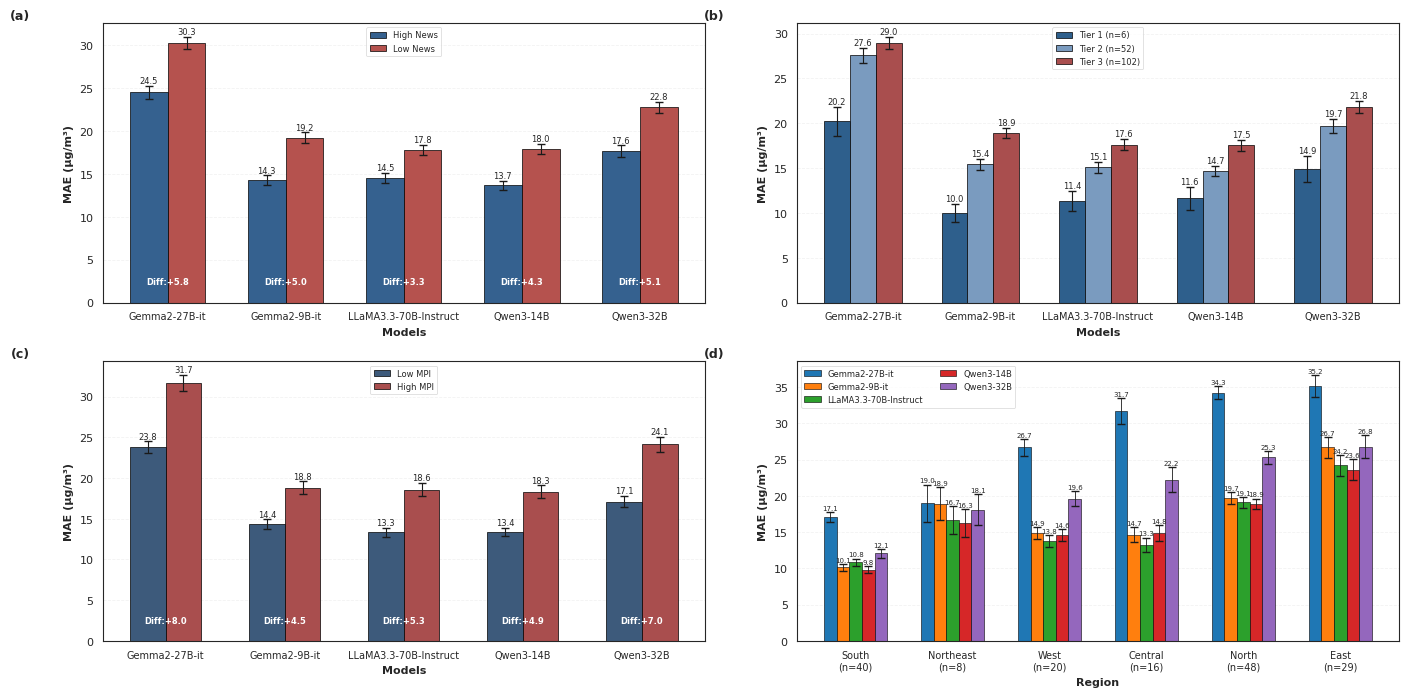

In [43]:
# Complete combined 2x2 plotting code (adds SE bars + Diff annotations)
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# Preferred rc / font setup
# -------------------------
# keep your latexify settings but ensure vector fonts for crisp PDF text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

# call your latexify to set sizes/figure defaults (uses your function)
latexify(fig_width=14, fig_height=7.0, columns=2)

# -------------------------
# Helper: safe SE compute
# -------------------------
def compute_se_from_stats(std, count):
    if count <= 1 or pd.isna(std):
        return 0.0
    return std / np.sqrt(count)

# -------------------------
# Recompute aggregates used by panels (robust)
# -------------------------

# (A) News / Media Presence
# news_raw_df must have columns ['Model','Group','abs_error'] where Group in {'High News','Low News'}
agg_news = news_raw_df.groupby(['Model','Group'])['abs_error'].agg(['mean','std','count']).reset_index()
agg_news['se'] = agg_news.apply(lambda r: compute_se_from_stats(r['std'], r['count']), axis=1)
pivot_mean_news = agg_news.pivot(index='Model', columns='Group', values='mean')
pivot_se_news   = agg_news.pivot(index='Model', columns='Group', values='se')

# ensure both groups columns exist (prevents KeyError)
for g in ['High News','Low News']:
    if g not in pivot_mean_news.columns:
        pivot_mean_news[g] = np.nan
    if g not in pivot_se_news.columns:
        pivot_se_news[g] = np.nan

models_a = pivot_mean_news.index.tolist()
groups_a = ['High News','Low News']

# (B) Tier
# tier_raw_df must have ['Model','Tier','abs_error'] with Tier values e.g. 'tier1','tier2','tier3'
tier_order = ['tier1','tier2','tier3']
agg_tier = tier_raw_df.groupby(['Model','Tier'])['abs_error'].agg(['mean','std','count']).reset_index()
agg_tier['se'] = agg_tier.apply(lambda r: compute_se_from_stats(r['std'], r['count']), axis=1)
pivot_mean_tier = agg_tier.pivot(index='Model', columns='Tier', values='mean')
pivot_se_tier   = agg_tier.pivot(index='Model', columns='Tier', values='se')
# ensure tiers exist
for t in tier_order:
    if t not in pivot_mean_tier.columns:
        pivot_mean_tier[t] = np.nan
    if t not in pivot_se_tier.columns:
        pivot_se_tier[t] = np.nan
models_b = pivot_mean_tier.index.tolist()

# attempt to read tier city counts if present (fallback 0)
try:
    t1n, t2n, t3n
except NameError:
    try:
        t1n = tier1_cities
        t2n = tier2_cities
        t3n = tier3_cities
    except Exception:
        t1n = t2n = t3n = 0

# (C) MPI (poverty)
# raw_df must have ['model','mpi_group','abs_error'] where mpi_group in {'Low MPI','High MPI'}
agg_mpi = raw_df.groupby(['model','mpi_group'])['abs_error'].agg(['mean','std','count']).reset_index()
agg_mpi['se'] = agg_mpi.apply(lambda r: compute_se_from_stats(r['std'], r['count']), axis=1)
pivot_mean_mpi = agg_mpi.pivot(index='model', columns='mpi_group', values='mean')
pivot_se_mpi   = agg_mpi.pivot(index='model', columns='mpi_group', values='se')
# ensure both groups exist
for g in ['Low MPI','High MPI']:
    if g not in pivot_mean_mpi.columns:
        pivot_mean_mpi[g] = np.nan
    if g not in pivot_se_mpi.columns:
        pivot_se_mpi[g] = np.nan
models_c = pivot_mean_mpi.index.tolist()
groups_c = ['Low MPI','High MPI']
try:
    low_n, high_n
except NameError:
    # try to infer from earlier results if available
    try:
        low_n = int(raw_df[raw_df['mpi_group']=='Low MPI']['city'].nunique())
        high_n = int(raw_df[raw_df['mpi_group']=='High MPI']['city'].nunique())
    except Exception:
        low_n = high_n = 0

# (D) Regional
# regional_raw_df must have ['Region','Model','abs_error','city']
agg_reg = regional_raw_df.groupby(['Region','Model'])['abs_error'].agg(['mean','std','count']).reset_index()
agg_reg['se'] = agg_reg.apply(lambda r: compute_se_from_stats(r['std'], r['count']), axis=1)
pivot_mean_reg = agg_reg.pivot(index='Region', columns='Model', values='mean')
pivot_se_reg   = agg_reg.pivot(index='Region', columns='Model', values='se')

# order regions by average MAE (best -> worst)
region_order = pivot_mean_reg.mean(axis=1).sort_values().index.tolist()
pivot_mean_reg = pivot_mean_reg.reindex(index=region_order)
pivot_se_reg   = pivot_se_reg.reindex(index=region_order)
selected_models_d = pivot_mean_reg.columns.tolist()

# region city counts mapping fallback
try:
    region_cities_map = region_cities
except NameError:
    region_cities_map = {r: regional_raw_df[regional_raw_df['Region']==r]['city'].nunique() for r in region_order}

# -------------------------
# Build the 2x2 figure
# -------------------------
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 7.0), constrained_layout=True)

# -------------------------
# Panel (a) News / Media Presence
# -------------------------
ax = ax1
x = np.arange(len(models_a))
w = 0.32

for i, grp in enumerate(groups_a):
    means = pivot_mean_news[grp].reindex(models_a).values
    ses   = pivot_se_news[grp].reindex(models_a).values
    offset = (i - 0.5) * w
    mask = ~np.isnan(means)
    bars = ax.bar(x[mask] + offset, means[mask], w,
                  label=grp,
                  color=('#35618f' if grp == 'High News' else '#b5524e'),
                  edgecolor='black', linewidth=0.5,
                  yerr=ses[mask], capsize=3, error_kw={'elinewidth':0.8})
    # numeric labels above error bar
    valid_idx = np.where(mask)[0]
    for j, bar in enumerate(bars):
        idx = valid_idx[j]
        h = bar.get_height()
        se_val = ses[idx] if not np.isnan(ses[idx]) else 0.0
        ax.text(bar.get_x()+bar.get_width()/2, h + se_val + 0.3, f'{h:.1f}', ha='center', fontsize=6)

# add Diff annotations robustly (Low - High) with bbox
high_vals = pivot_mean_news['High News'].reindex(models_a).values
low_vals  = pivot_mean_news['Low News'].reindex(models_a).values
# compute a small y offset relative to plotted heights
combined_max = np.nanmax(np.column_stack([
    np.nan_to_num(high_vals, nan=0.0) + np.nan_to_num(pivot_se_news['High News'].reindex(models_a).values, nan=0.0),
    np.nan_to_num(low_vals,  nan=0.0) + np.nan_to_num(pivot_se_news['Low News'].reindex(models_a).values,  nan=0.0)
]))
y_text_offset = combined_max * 0.06 if combined_max > 0 else 1.0

for i in range(len(models_a)):
    if np.isnan(low_vals[i]) or np.isnan(high_vals[i]):
        continue
    diff = low_vals[i] - high_vals[i]
    # bbox = dict(facecolor=('#b5524e' if diff > 0 else '#35618f'), edgecolor='none', pad=0.3, alpha=0.9)
    ax.text(i, y_text_offset, f'Diff:{diff:+.1f}', ha='center', va='bottom', fontsize=6, color='white', fontweight='bold')

ax.set_xticks(np.arange(len(models_a)))
ax.set_xticklabels(models_a, fontsize=7)
ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Models', fontsize=8, fontweight='bold')
ax.legend(fontsize=6, frameon=True, loc='upper center')
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.6)
ax.text(-0.12, 1.05, '(a)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# -------------------------
# Panel (b) Tier bias
# -------------------------
ax = ax2
models_b = pivot_mean_tier.index.tolist()
x = np.arange(len(models_b)); w = 0.22

for i, tier in enumerate(tier_order):
    means = pivot_mean_tier[tier].reindex(models_b).values
    ses   = pivot_se_tier[tier].reindex(models_b).values
    positions = x + (i - 1) * w
    mask = ~np.isnan(means)
    bars = ax.bar(positions[mask], means[mask], w,
                  label=f'Tier {tier[-1]} (n={ [t1n, t2n, t3n][i] })',
                  color=({'tier1':'#2E5F8C','tier2':'#7A9BBF','tier3':'#A94E4E'}[tier]),
                  edgecolor='black', linewidth=0.5,
                  yerr=ses[mask], capsize=3, error_kw={'elinewidth':0.8})
    valid_idx = np.where(mask)[0]
    for j, bar in enumerate(bars):
        idx = valid_idx[j]
        h = bar.get_height()
        se_val = ses[idx] if not np.isnan(ses[idx]) else 0.0
        ax.text(bar.get_x()+bar.get_width()/2, h + se_val + 0.3, f'{h:.1f}', ha='center', fontsize=6)

ax.set_xticks(np.arange(len(models_b)))
ax.set_xticklabels(models_b, fontsize=7)
ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Models', fontsize=8, fontweight='bold')
ax.legend(fontsize=6, frameon=True, loc='upper center')
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.6)
ax.text(-0.12, 1.05, '(b)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# -------------------------
# Panel (c) MPI (poverty)
# -------------------------
ax = ax3
models_c = pivot_mean_mpi.index.tolist()
x = np.arange(len(models_c)); w = 0.30

for i, grp in enumerate(groups_c):
    means = pivot_mean_mpi[grp].reindex(models_c).values
    ses   = pivot_se_mpi[grp].reindex(models_c).values
    offset = (i - 0.5) * w
    mask = ~np.isnan(means)
    bars = ax.bar(x[mask] + offset, means[mask], w,
                  label=grp,
                  color=('#3D5A7B' if grp == 'Low MPI' else '#A94E4E'),
                  edgecolor='black', linewidth=0.5,
                  yerr=ses[mask], capsize=3, error_kw={'elinewidth':0.8})
    valid_idx = np.where(mask)[0]
    for j, bar in enumerate(bars):
        idx = valid_idx[j]
        h = bar.get_height()
        se_val = ses[idx] if not np.isnan(ses[idx]) else 0.0
        ax.text(bar.get_x()+bar.get_width()/2, h + se_val + 0.3, f'{h:.1f}', ha='center', fontsize=6)

# add Diff (High - Low) robustly with bbox
low_vals = pivot_mean_mpi['Low MPI'].reindex(models_c).values
high_vals = pivot_mean_mpi['High MPI'].reindex(models_c).values
combined_max_mpi = np.nanmax(np.column_stack([
    np.nan_to_num(low_vals, nan=0.0) + np.nan_to_num(pivot_se_mpi['Low MPI'].reindex(models_c).values, nan=0.0),
    np.nan_to_num(high_vals, nan=0.0) + np.nan_to_num(pivot_se_mpi['High MPI'].reindex(models_c).values, nan=0.0)
]))
y_text_offset_mpi = combined_max_mpi * 0.06 if combined_max_mpi > 0 else 1.0

for i in range(len(models_c)):
    if np.isnan(low_vals[i]) or np.isnan(high_vals[i]):
        continue
    diff = high_vals[i] - low_vals[i]
    # bbox = dict(facecolor=('#A94E4E' if diff > 0 else '#3D5A7B'), edgecolor='none', pad=0.3, alpha=0.9)
    ax.text(i, y_text_offset_mpi, f'Diff:{diff:+.1f}', ha='center', va='bottom', fontsize=6, color='white', fontweight='bold')

ax.set_xticks(np.arange(len(models_c)))
ax.set_xticklabels(models_c, fontsize=7)
ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Models', fontsize=8, fontweight='bold')
ax.legend(fontsize=6, frameon=True, loc='upper center')
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.6)
ax.text(-0.12, 1.05, '(c)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# -------------------------
# Panel (d) Regional / Geographic
# -------------------------
ax = ax4
n_regions = len(region_order)
x = np.arange(n_regions); w = 0.13
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']

for i, model in enumerate(selected_models_d):
    color = colors[i % len(colors)]
    mae_vals = pivot_mean_reg[model].reindex(region_order).values
    se_vals  = pivot_se_reg[model].reindex(region_order).values
    offset = (i - len(selected_models_d)/2 + 0.5) * w
    mask = ~np.isnan(mae_vals)
    bars = ax.bar(x[mask] + offset, mae_vals[mask], w,
                  label=model, color=color, edgecolor='black', linewidth=0.4,
                  yerr=se_vals[mask], capsize=3, error_kw={'elinewidth':0.6})
    valid_idx = np.where(mask)[0]
    for j, bar in enumerate(bars):
        idx = valid_idx[j]
        h = bar.get_height()
        se_val = se_vals[idx] if not np.isnan(se_vals[idx]) else 0.0
        ax.text(bar.get_x()+bar.get_width()/2, h + se_val + 0.25, f'{h:.1f}', ha='center', fontsize=5)

ax.set_xticks(np.arange(len(region_order)))
ax.set_xticklabels([f"{r}\n(n={region_cities_map.get(r,0)})" for r in region_order], fontsize=7)
ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Region', fontsize=8, fontweight='bold')
ax.legend(fontsize=6, frameon=True, loc='upper left', ncol=2)
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.6)
ax.text(-0.12, 1.05, '(d)', transform=ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

# -------------------------
# Final layout, save and show
# -------------------------
plt.tight_layout()
plt.savefig('figure12.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()